# Introduction

In this notebook I perform analysis to assess how similar the left and right-hand side data are to each other, for each user:
1. Time-Lagged Cross Correlation Analysis, which looks at the linear correlation between two signals at different lags. This measure, however, assumes stationarity of the whole time series, i.e., the average does not depend on time. This assumption is most likely not satisfied by our data.
2. Detrended-cross correlation analysis. Here, I consider the max correlation achieved in the analysis (which is performed over different lags). This measure is data-independent, corrects for non-stationarity in the timeseries, which might indeed skew traditional cross-correlation. For reference on the method, see [1] and [2].
3. Coherence Analysis, which allows to see which frequencies interact the most between two signals. However, even in this setting, non-stationary time series might create problems, see [3].
4. Dynamic Time Warping Distance. This, however, is a distance, and as such is problem dependent. It is not very clear how to compare DTWD between BVP and EDA signals.

--- 
*References*

[1] Podobnik, Boris, and H. Eugene Stanley. "Detrended cross-correlation analysis: a new method for analyzing two nonstationary time series." Physical review letters 100.8 (2008): 084102.

[2] Shen, Chenhua. "Analysis of detrended time-lagged cross-correlation between two nonstationary time series." Physics Letters A 379.7 (2015): 680-687.

[3] White, Langford B., and Boualem Boashash. "Cross spectral analysis of nonstationary processes." IEEE Transactions on Information Theory 36.4 (1990): 830-835.

# Data Loading

In [1]:
from pandas import read_csv, read_parquet
from glob import glob
from collections import defaultdict
from pandas import Series
from tqdm.auto import tqdm
from plotly.subplots import make_subplots
from plotly.graph_objects import Figure, Scatter
from random import choice as choose_randomly
from pandas import Timestamp
from pandas.core.indexes.base import Index
from tqdm.notebook import tqdm
from pandas import DataFrame, IndexSlice
from gc import collect as garbage_collect
from joblib import Parallel, delayed

eda_data_base_path: str = "../data.nosync/mwc2022/filtered/*/EDA/*.parquet"
acc_data_base_path: str = "../data.nosync/mwc2022/filtered/*/ACC/*.parquet"
bvp_data_base_path: str = "../data.nosync/mwc2022/filtered/*/BVP/*.parquet"

eda_data_paths: list[str] = glob(eda_data_base_path)
acc_data_paths: list[str] = glob(acc_data_base_path)
eda_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
    lambda: defaultdict()
)
for file in tqdm(eda_data_paths, desc="Loading EDA data"):
    side_name = file.split("/")[-3]
    user_name = file.split("/")[-1].split(".")[0]
    eda_data[side_name][user_name] = read_parquet(file)
    
   
acc_data = None
# acc_data: defaultdict[str, defaultdict[str, Series]] = defaultdict(
#     lambda: defaultdict()
# ) 
# for file in tqdm(acc_data_paths, desc="Loading ACC data"):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     acc_data[side_name][user_name] = read_parquet(file)

bvp_data = None

# bvp_data_paths = glob(bvp_data_base_path)
# bvp_data = defaultdict(lambda: defaultdict())

# def load_bvp_data(file):
#     side_name = file.split("/")[-3]
#     user_name = file.split("/")[-1].split(".")[0]
#     return side_name, user_name, read_parquet(file)

# results = Parallel(n_jobs=-1, backend='threading')(
#     delayed(load_bvp_data)(file) for file in tqdm(bvp_data_paths, desc="Loading BVP data")
# )

# for side_name, user_name, data in results:
#     bvp_data[side_name][user_name] = data
    
    
physiological_data: dict[str, defaultdict[str, defaultdict[str, Series]]] = {
    "EDA": eda_data,
    "BVP": bvp_data,
    'ACC': acc_data,
}
del eda_data
del bvp_data
del acc_data
garbage_collect()

Loading EDA data:   0%|          | 0/19 [00:00<?, ?it/s]

57

## Trimming to the shortest series

In the MWC2022 data, there is no beginning and end of the experiment. However, the data from the left and right side should still be matched in length. In order to do this, I decided to trim to the shortest of the two signals.

In [2]:
from pandas import to_datetime, Timedelta, DatetimeIndex, MultiIndex


def correct_session_idx(session_name: str):
    session_time: str = session_name.split("-")[1]
    if session_time[0] == "0":
        session_id_corrected: Timestamp = to_datetime(
            session_name.split("-")[0], format="%y%m%d"
        )
    else:
        session_id_corrected: Timestamp = to_datetime(
            session_name.split("-")[0], format="%y%m%d"
        ) + Timedelta("1D")
    session_id_corrected: str = str(session_id_corrected.date())
    return session_id_corrected


def super_correct_session_idx(idx):
    correct = [correct_session_idx(el) for el in idx]
    if len(correct) > len(set(correct)):
        new_correct = []
        i = 0
        for el in correct:
            if el in new_correct:
                new_correct.append(el + f"_{i}")
                i += 1
            else:
                new_correct.append(el)
                i = 0
        correct = new_correct
    return correct


def correct_session_names(df: DataFrame):
    df.index = df.index.set_levels(
        super_correct_session_idx(df.index.levels[0]), level=0
    )
    return df


In [3]:
physiological_data['BVP'] = {side: {
    user: correct_session_names(user_data)
    for user, user_data in tqdm(side_data.items(), desc='User progress')
}
for side, side_data in physiological_data['BVP'].items()}

AttributeError: 'NoneType' object has no attribute 'items'

In [4]:
new_physiological_data = defaultdict(
        lambda: defaultdict(lambda : defaultdict(lambda : defaultdict()))
    )

for signal_name, signal_data in physiological_data.items():
    if signal_data is None:
        continue
    users_left = list(signal_data["left"].keys())
    users_right = list(signal_data["right"].keys())
    users = list(set(users_left) & set(users_right))
    for user in tqdm(users, desc=f"Processing {signal_name} data. User progress"):
        user_data_left: DataFrame = signal_data["left"][user]
        user_data_right: DataFrame = signal_data["right"][user]
        sessions_left = user_data_left.index.get_level_values("session").unique()
        sessions_right = user_data_right.index.get_level_values("session").unique()
        sessions = list(set(sessions_left) & set(sessions_right))
        for session in sessions:
            session_data_left = user_data_left.loc[IndexSlice[session, :], :].droplevel(
                level=0, axis=0
            )
            session_data_right = user_data_right.loc[
                IndexSlice[session, :], :
            ].droplevel(level=0, axis=0)

            max_start = max(
                session_data_left.index.get_level_values("timestamp").min(),
                session_data_right.index.get_level_values("timestamp").min(),
            )
            min_end = min(
                session_data_left.index.get_level_values("timestamp").max(),
                session_data_right.index.get_level_values("timestamp").max(),
            )

            session_data_left = session_data_left[
                (session_data_left.index >= max_start)
                & (session_data_left.index <= min_end)
            ]
            session_data_right = session_data_right[
                (session_data_right.index >= max_start)
                & (session_data_right.index <= min_end)
            ]
            if session_data_left.shape != session_data_right.shape:
                longest_index = (
                    session_data_left.index
                    if session_data_left.shape[0] > session_data_right.shape[0]
                    else session_data_right.index
                )
                shortest_index = (
                    session_data_right.index
                    if session_data_left.shape[0] > session_data_right.shape[0]
                    else session_data_left.index
                )
                for el in longest_index:
                    if el not in shortest_index:
                        cutoff_index = el
                        break
                session_data_left = session_data_left[
                    (session_data_left.index < cutoff_index)
                ]
                session_data_right = session_data_right[
                    (session_data_right.index < cutoff_index)
                ]
                if session_data_left.shape != session_data_right.shape:
                    raise RuntimeError('fuck')
            
            if len(session_data_left) == 0:
                raise RuntimeError('double fuck')
            new_physiological_data[signal_name]['left'][user][session] = session_data_left
            new_physiological_data[signal_name]['right'][user][session] = session_data_right


Processing EDA data. User progress:   0%|          | 0/8 [00:00<?, ?it/s]

# Checking Stationarity

In [5]:
physiological_data['EDA']['left']['U04']

mixed-EDA  phasic-EDA
session    timestamp                                              
2022-11-24 2022-11-23 22:59:05+01:00         -1.027426   -0.360254
           2022-11-23 22:59:05.250000+01:00  -1.014035   -0.360254
           2022-11-23 22:59:05.500000+01:00  -0.999167   -0.060415
           2022-11-23 22:59:05.750000+01:00  -0.975134    0.612855
           2022-11-23 22:59:06+01:00         -0.939876    1.080269
...                                                ...         ...
2022-12-15 2022-12-15 07:22:17.250000+01:00  -0.524231    3.801022
           2022-12-15 07:22:17.500000+01:00  -0.517816    3.357688
           2022-12-15 07:22:17.750000+01:00  -0.517260    2.953734
           2022-12-15 07:22:18+01:00         -0.523066    2.588399
           2022-12-15 07:22:18.250000+01:00  -0.536335    2.259838

[1531782 rows x 2 columns]

In [6]:
from typing import Callable
from arch.unitroot import KPSS
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap
from collections import defaultdict
from pandas import Series
from warnings import warn
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False, nb_workers=8)


def check_stationarity(
    physiological_data: dict[str, defaultdict[str, defaultdict[str, DataFrame]]],
    signal: str,
    data_source: str,
    stationarity_method: Callable = KPSS,
    invert_pvalues: bool = False,
    nested: bool = False,
    no_plot: bool = False,
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))

    statistical_test = {
        side: {
            user: (
                physiological_data[signal][side][user]
                .iloc[:, [0]]
                .groupby(axis=0, level=0)
                .parallel_apply(lambda x: stationarity_method(x.values).pvalue)
                .to_dict()
                if not invert_pvalues
                else physiological_data[signal][side][user]
                .iloc[:, [0]]
                .groupby(axis=0, level=0)
                .parallel_apply(lambda x: 1 - stationarity_method(x.values).pvalue)
                .to_dict()
            )
            if physiological_data[signal][side][user].iloc[:, 0].values.shape[0] > 0
            else None
            for user in tqdm(user_list, desc="User progress", colour="blue")
        }
        for side in ["left", "right"]
    }
    if nested:
        reform = {
            (outerKey, innerKey): values
            for outerKey, innerDict in statistical_test.items()
            for innerKey, values in innerDict.items()
        }
        df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
    else:
        df_to_save: DataFrame = DataFrame(statistical_test).sort_index().T
    if not no_plot:
        figure(figsize=(len(df_to_save.columns), len(df_to_save)))
        heatmap(
            df_to_save,
            xticklabels=df_to_save.columns,
            vmax=1,
            vmin=0,
            center=0,
            cmap="coolwarm",
            yticklabels=df_to_save.index,
            annot=True,
        )
        title(f"P-values of {stationarity_method.__name__} test ({signal})")
        savefig(
            f"../visualizations/{stationarity_method.__name__}_pvalues_{signal}_{data_source}.pdf",
            bbox_inches="tight",
        )
        show()
        return df_to_save
    else:
        return statistical_test


<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## EDA

In [7]:
from arch.unitroot import DFGLS, KPSS, ADF, PhillipsPerron, ZivotAndrews
signal: str = "EDA"

User progress:   0%|          | 0/8 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m

User progress:   0%|          | 0/8 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan


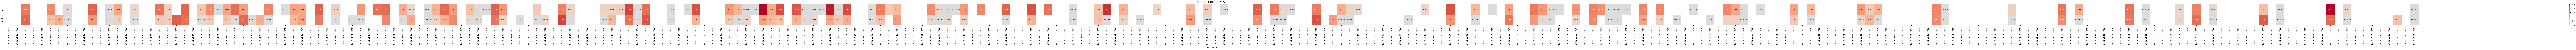

Sessions w/o stationarity


left     99
right    72
dtype: int64

Sessions w stationarity


right    51
left     34
dtype: int64

In [8]:
test_result = check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    data_source='mwc2022',
    invert_pvalues=False,
    nested=True,
    stationarity_method=ADF,
)

print(f'Sessions w/o stationarity')
display(test_result[test_result > 0.05].count(axis=1).sort_values(ascending=False))
print(f'Sessions w stationarity')
display(test_result[test_result < 0.05].count(axis=1).sort_values(ascending=False))

In [9]:
test_result.to_csv("../test_results/ADF_pvalues_mwc2022.csv")

User progress:   0%|          | 0/8 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = emp

User progress:   0%|          | 0/8 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = empty((m + maxlag, m + maxlag)) * nan
/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/arch/unitroot/unitroot.py:248: RuntimeWarning: invalid value encountered in multiply
  xpx = emp

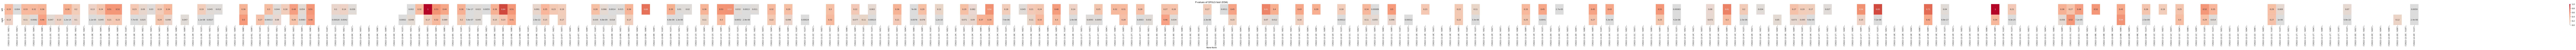

Sessions w/o stationarity


left     106
right     67
dtype: int64

Sessions w stationarity


right    56
left     27
dtype: int64

In [56]:
test_result = check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    data_source='mwc2022',
    nested=True,
    stationarity_method=DFGLS,
)
print(f'Sessions w/o stationarity')
display(test_result[test_result > 0.05].count(axis=1).sort_values(ascending=False))
print(f'Sessions w stationarity')
display(test_result[test_result < 0.05].count(axis=1).sort_values(ascending=False))

User progress:   0%|          | 0/8 [00:00<?, ?it/s]

User progress:   0%|          | 0/8 [00:00<?, ?it/s]

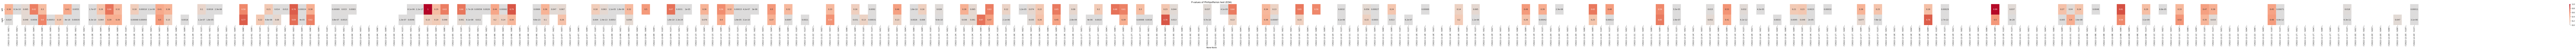

Sessions w/o stationarity


left     80
right    53
dtype: int64

Sessions w stationarity


right    70
left     53
dtype: int64

In [57]:
test_result = check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    data_source='mwc2022',
    nested=True,
    stationarity_method=PhillipsPerron,
)
print(f'Sessions w/o stationarity')
display(test_result[test_result > 0.05].count(axis=1).sort_values(ascending=False))
print(f'Sessions w stationarity')
display(test_result[test_result < 0.05].count(axis=1).sort_values(ascending=False))

User progress:   0%|          | 0/8 [00:00<?, ?it/s]

User progress:   0%|          | 0/8 [00:00<?, ?it/s]

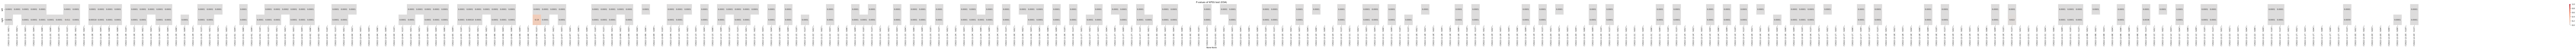

Sessions w/o stationarity


right    1
left     0
dtype: int64

Sessions w stationarity


left     133
right    122
dtype: int64

In [58]:
test_result = check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    data_source='mwc2022',
    nested=True,
    stationarity_method=KPSS,
)
print(f'Sessions w/o stationarity')
display(test_result[test_result > 0.05].count(axis=1).sort_values(ascending=False))
print(f'Sessions w stationarity')
display(test_result[test_result < 0.05].count(axis=1).sort_values(ascending=False))

## BVP

In [60]:
from arch.unitroot import DFGLS, KPSS, ADF, PhillipsPerron, ZivotAndrews
signal: str = "BVP"

In [64]:
test_result = check_stationarity(
    physiological_data=physiological_data,
    signal=signal,
    invert_pvalues=False,
    data_source='mwc2022',
    nested=True,
    no_plot=True,
    stationarity_method=PhillipsPerron,
)

User progress:   0%|          | 0/8 [00:00<?, ?it/s]

User progress:   0%|          | 0/8 [00:00<?, ?it/s]

Sessions w/o stationarity


TypeError: '>' not supported between instances of 'dict' and 'float'

In [66]:
reform = {
            (outerKey, innerKey): values
            for outerKey, innerDict in test_result.items()
            for innerKey, values in innerDict.items()
        }
df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
print(f'Sessions w/o stationarity')
display(df_to_save[df_to_save > 0.05].count(axis=1).sort_values(ascending=False))
print(f'Sessions w stationarity')
display(df_to_save[df_to_save < 0.05].count(axis=1).sort_values(ascending=False))

Sessions w/o stationarity


left     0
right    0
dtype: int64

Sessions w stationarity


left     137
right    125
dtype: int64

# Time-Lagged Detrended Cross-Correlation

In [8]:
from sys import path

path.append("../")
from warnings import warn

from joblib import Parallel, delayed
from numpy import nan, ndarray
from pandas import DataFrame
from tqdm.notebook import tqdm

from src.utils.dcca import detrended_correlation
from src.utils.dcca.cross_correlation import cross_correlation
from src.utils.plots import plot_heatmap_boxplot


def time_lagged_cross_correlation_per_user(
    right_side_data: ndarray,
    left_side_data: ndarray,
    time_scale: int | None = None,
    max_time_lag: int | None = None,
    detrended: bool = True,
    n_jobs: int = -1,
    **kwargs,
) -> list[float]:
    if max_time_lag is None:
        max_time_lag = len(right_side_data)
    # TODO: implement negative time lags

    if right_side_data.shape[0] == 0 or left_side_data.shape[0] == 0:
        warn(f'No data for current input {kwargs.get("progress_item_name", None)}')
        return []
    time_lags = range(0, max_time_lag)

    if detrended:
        if time_scale is None:
            raise ValueError(
                f"time_scale must be provided for detrended correlation. Given {time_scale}"
            )
        try:
            result = Parallel(n_jobs=n_jobs, backend='threading')(
                delayed(detrended_correlation)(
                    x=right_side_data,
                    y=left_side_data,
                    time_scale=time_scale,
                    time_lag=time_lag,
                )
                for time_lag in tqdm(
                    time_lags,
                    desc=f'Calculating detrended cross correlation {kwargs.get("progress_item_name", None)}',
                    colour=kwargs.get("tqdm_color", "green"),
                )
            )
        except ValueError as e:
            print(
                f"{right_side_data.shape=}, {left_side_data.shape=}, {time_scale=}, {time_lags=}"
            )
            raise e
        return result
    else:
        warn("Calculation is not parallel. n_jobs ignored.")
        return [
            cross_correlation(x=right_side_data, y=left_side_data, time_lag=time_lag)
            for time_lag in tqdm(
                time_lags,
                desc=f'Calculating cross correlation {kwargs.get("progress_item_name", None)}',
                colour=kwargs.get("tqdm_color", "green"),
            )
        ]


def perform_correlation(
    physiological_data: dict,
    signal: str,
    data_name: str,
    time_scale: int | None = None,
    max_time_lag: int = 200,
    detrended: bool = True,
    measure_name: str = "max dcca",
    n_jobs: int = -1,
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))
    # physiological_data[signal][side][user]
    #             .iloc[:, [0]]
    #             .groupby(axis=0, level=0)
    #             .parallel_apply(lambda x: stationarity_method(x.values).pvalue)
    #             .to_dict()

    dccas = {
        user: {
            session_name: time_lagged_cross_correlation_per_user(
                right_side_data=physiological_data[signal]["right"][user][session_name].iloc[:,0].values,
                left_side_data=physiological_data[signal]["left"][user][session_name].iloc[:,0].values,
                time_scale=time_scale,
                detrended=detrended,
                max_time_lag=max_time_lag,
                n_jobs=n_jobs,
                progress_item_name=f"{user}_{session_name}",
            )
            for session_name in list(
                set(
                    physiological_data[signal]["right"][user].keys()
                )
                & set(
                    physiological_data[signal]["left"][user].keys()
                )
            )
        }
        for user in tqdm(user_list, desc="User progress", colour="blue")
    }

    max_dccas = {
        user: max(dcca) if len(dcca) > 0 else nan for user, dcca in dccas.items()
    }
    try:
        plot_heatmap_boxplot(
            data=max_dccas,
            measure_name=measure_name,
            nested=True,
            vmax=1,
            vmin=-1,
            center=0,
            data_name=data_name,
        )
        return dccas
    except:
        return dccas


## EDA

In [129]:
signal: str = "EDA"
time_scale: int = 20
dcca = perform_correlation(
    physiological_data=new_physiological_data,
    signal=signal,
    time_scale=time_scale,
    detrended=True,
    max_time_lag=32*2,
    measure_name="max dcca",
    data_name='mwc2022',
    n_jobs=-1,
)


User progress:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-07:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-10:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-20:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-26:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-30:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-19:   0%|          | 0/64 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Calculating detrended cross correlation U13_2022-12-05:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-13:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-27:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-25:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-29:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-28:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-21:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-02:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-03:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-22:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-24:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-08:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-14:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-12:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-22:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-19:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-23:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-17:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-21:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-06:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-20:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-18:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-11-17:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-16:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-18:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-01:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U13_2022-12-09:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U10_2022-12-05:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U10_2022-12-07:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U10_2022-12-12:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U10_2022-12-21:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U10_2022-12-03:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U10_2022-12-22:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U10_2022-12-16:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U01_2022-12-05:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U01_2022-12-07:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U01_2022-12-04:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U01_2022-11-29:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U01_2022-11-25:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U01_2022-11-28:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U01_2022-12-06:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U01_2022-12-02:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U01_2022-12-15:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U01_2022-12-13:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U01_2022-12-01:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U01_2022-12-09:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-11-26:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-11-19:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-12-13:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-11-27:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-11-28:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-11-21:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-12-15:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-11-22:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-11-24:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-12-14:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-12-19:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-11-23:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-12-17:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-12-11:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-12-21:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-11-20:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-11-18:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-12-18:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U09_2022-12-16:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-12-05:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-12-14:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-12-12:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-11-29:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-11-25:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-12-11:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-11-26:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-11-28:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-12-06:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-12-02:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-12-15:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-11-30:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-12-13:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-11-24:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U06_2022-12-08:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U06_2022-12-05:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U06_2022-11-23:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U06_2022-11-25:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U06_2022-11-28:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U06_2022-12-06:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U06_2022-12-02:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U06_2022-12-01:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-05:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-07:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-23:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-27:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-10:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-25:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-29:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-11:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-26:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-28:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-06:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-02:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-03:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-22:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-30:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-24:   0%|          | 0/64 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-09:   0%|          | 0/64 [00:00<?, ?it/s]

In [130]:
from numpy import mean
max_dccas = {
    user: {
        session_name: max(session_dcca) if len(session_dcca) > 0 else nan
        for session_name, session_dcca in user_dcca.items()
    }
    for user, user_dcca in dcca.items()
}
avg_max_dccas = {
    user: mean(max_dcca)
    for user, user_dcca in max_dccas.items()
    for session_name, max_dcca in user_dcca.items()
}

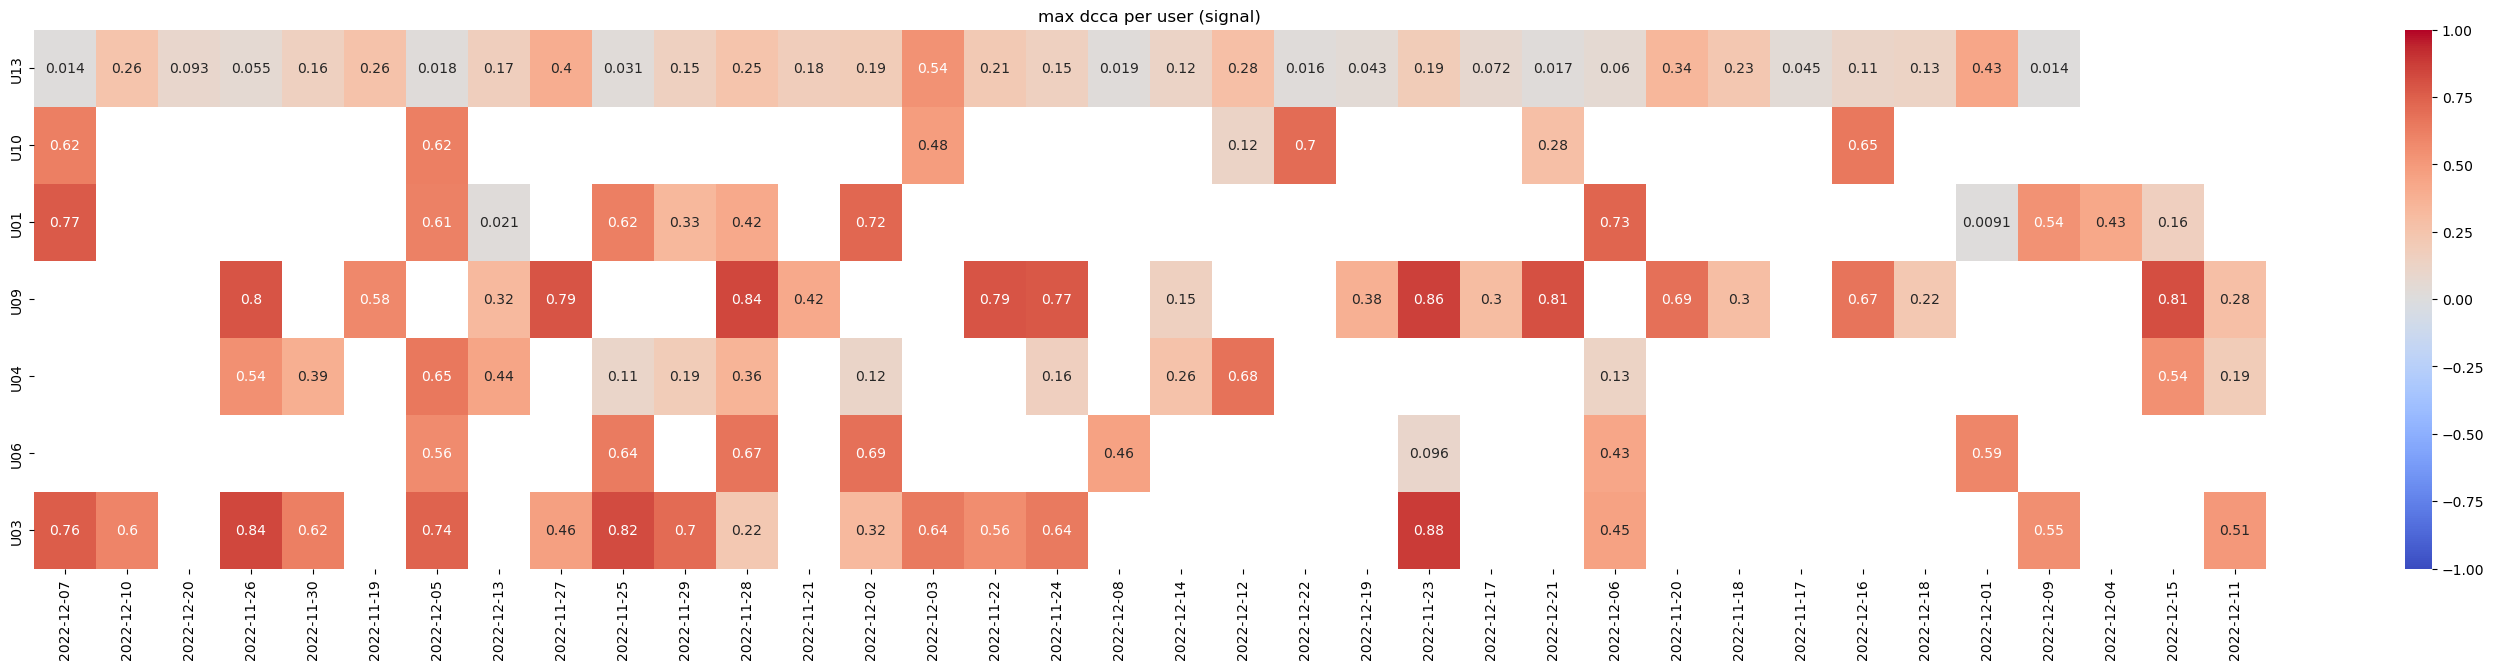

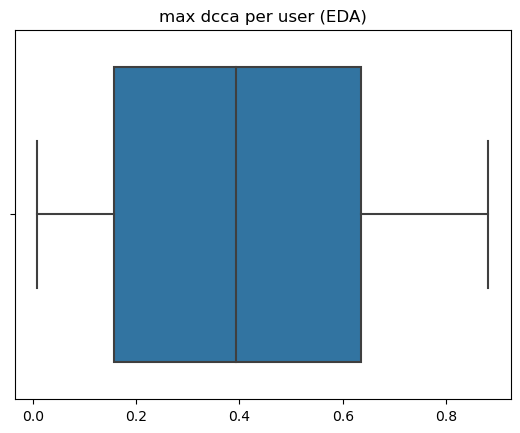

In [131]:
from seaborn import heatmap, boxplot
from matplotlib.pyplot import plot, savefig, show, style, figure, title

def plot_heatmap_boxplot(
    data: dict,
    signal: str,
    data_name: str = "",
    measure_name: str = "",
    nested: bool = False,
    **kwargs,
):
    if nested:
        # reform = {
        #     (outerKey, innerKey): values
        #     for outerKey, innerDict in data.items()
        #     for innerKey, values in innerDict.items()
        # }
        # df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
        df_to_save = DataFrame(data).T
    else:
        df_to_save: Series = Series(data)
        
        df_to_save: DataFrame = (
            DataFrame(df_to_save, columns=[measure_name]).sort_index().T
        )

    figure(figsize=(len(df_to_save.columns), len(df_to_save.index)))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=kwargs.get("vmax", 1),
        vmin=kwargs.get("vmin", -1),
        center=kwargs.get("center", 0),
        cmap=kwargs.get("cmap", "coolwarm"),
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"{measure_name} per user (signal)")
    savefig(
        f"../visualizations/user_{measure_name}_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

    boxplot(x=df_to_save.values)
    title(f"{measure_name} per user ({signal})")
    savefig(
        f"../visualizations/user_{measure_name}_boxplot_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()


plot_heatmap_boxplot(
            data=max_dccas,
            signal='EDA',
            measure_name="max dcca",
            nested=True,
            vmax=1,
            vmin=-1,
            center=0,
            data_name="mwc2022",
        )

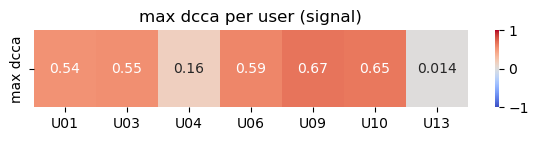

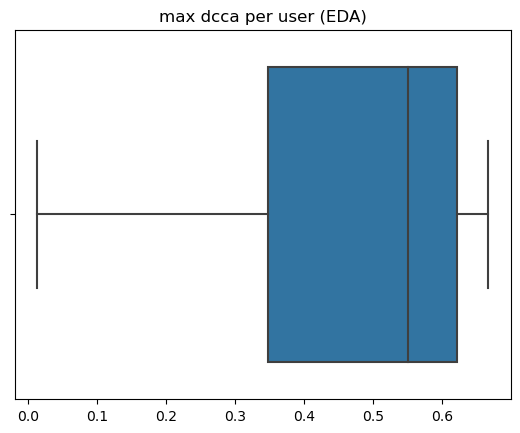

In [132]:
plot_heatmap_boxplot(
            data=avg_max_dccas,
            signal='EDA',
            measure_name="max dcca",
            nested=False,
            vmax=1,
            vmin=-1,
            center=0,
            data_name="mwc2022",
        )

## BVP

In [10]:
signal: str = "BVP"
time_scale: int = 20
dcca = perform_correlation(
    physiological_data=new_physiological_data,
    signal=signal,
    time_scale=time_scale,
    detrended=True,
    measure_name="max dcca",
    data_name='mwc2022',
    n_jobs=-1,
)


User progress:   0%|          | 0/7 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-28:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-24:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-11:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-06:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-03:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-26:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-29:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-23:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-25:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-02:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-10:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-09:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-05:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-30:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-22:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-12-07:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U03_2022-11-27:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-11-28:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating detrended cross correlation U04_2022-11-24:   0%|          | 0/200 [00:00<?, ?it/s]

: 

: 

In [ ]:
from numpy import mean
max_dccas = {
    user: {
        session_name: max(session_dcca) if len(session_dcca) > 0 else nan
        for session_name, session_dcca in user_dcca.items()
    }
    for user, user_dcca in dcca.items()
}
avg_max_dccas = {
    user: mean(max_dcca)
    for user, user_dcca in max_dccas.items()
    for session_name, max_dcca in user_dcca.items()
}

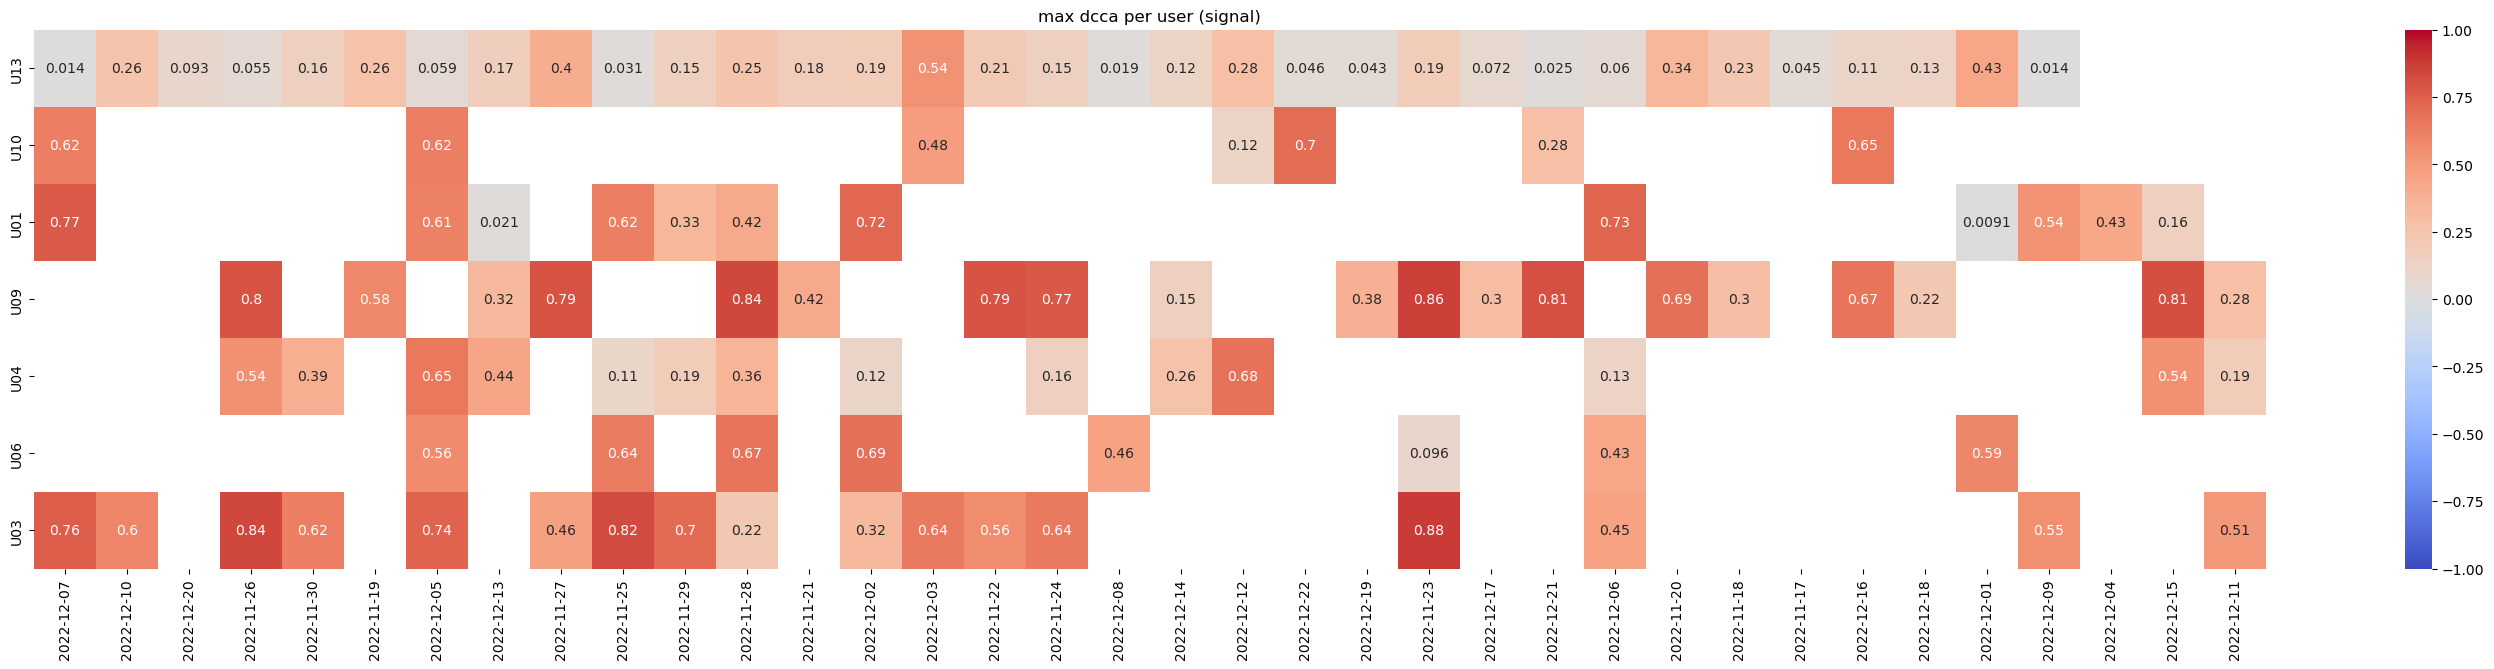

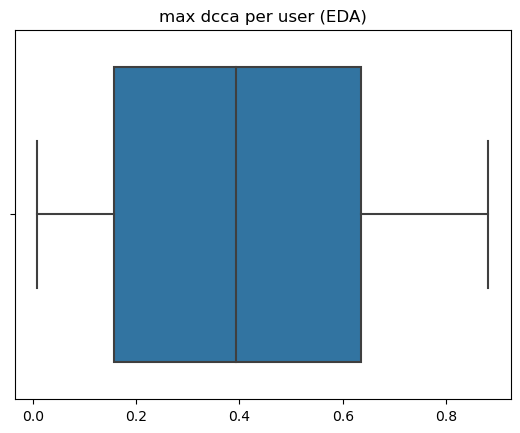

In [ ]:
from seaborn import heatmap, boxplot
from matplotlib.pyplot import plot, savefig, show, style, figure, title

def plot_heatmap_boxplot(
    data: dict,
    signal: str,
    data_name: str = "",
    measure_name: str = "",
    nested: bool = False,
    **kwargs,
):
    if nested:
        # reform = {
        #     (outerKey, innerKey): values
        #     for outerKey, innerDict in data.items()
        #     for innerKey, values in innerDict.items()
        # }
        # df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
        df_to_save = DataFrame(data).T
    else:
        df_to_save: Series = Series(data)
        
        df_to_save: DataFrame = (
            DataFrame(df_to_save, columns=[measure_name]).sort_index().T
        )

    figure(figsize=(len(df_to_save.columns), len(df_to_save.index)))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=kwargs.get("vmax", 1),
        vmin=kwargs.get("vmin", -1),
        center=kwargs.get("center", 0),
        cmap=kwargs.get("cmap", "coolwarm"),
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"{measure_name} per user (signal)")
    savefig(
        f"../visualizations/user_{measure_name}_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

    boxplot(x=df_to_save.values)
    title(f"{measure_name} per user ({signal})")
    savefig(
        f"../visualizations/user_{measure_name}_boxplot_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()


plot_heatmap_boxplot(
            data=max_dccas,
            signal=signal,
            measure_name="max dcca",
            nested=True,
            vmax=1,
            vmin=-1,
            center=0,
            data_name="mwc2022",
        )

# Time-Lagged Cross-Correlation

## EDA

User progress:   0%|          | 0/33 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:61: UserWarning: Calculation is not parallel. n_jobs ignored.
  warn("Calculation is not parallel. n_jobs ignored.")


Calculating cross correlation s074:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s071:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s097:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s048:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s039:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s052:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s038:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s066:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s098:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s096:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s072:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s042:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s037:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s092:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s044:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s081:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s065:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s047:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s073:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s049:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s088:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s059:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s075:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s045:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s083:   0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_14969/4239866153.py:31: UserWarning: No data for current input s040
  warn(f'No data for current input {kwargs.get("progress_item_name", None)}')


Calculating cross correlation s043:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s077:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s089:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s087:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s055:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s053:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation s099:   0%|          | 0/200 [00:00<?, ?it/s]

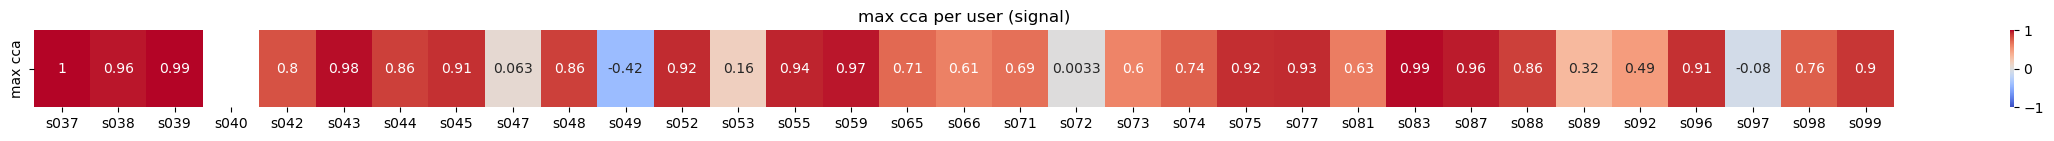

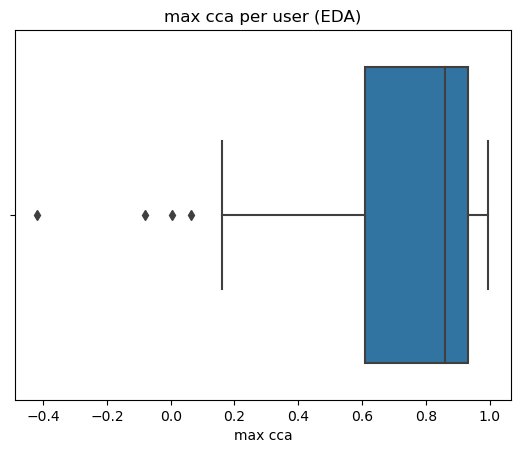

In [6]:
signal: str = "EDA"
time_scale: int = 20
perform_correlation(
    physiological_data=new_physiological_data,
    signal=signal,
    time_scale=time_scale,
    detrended=False,
    measure_name="max cca",
)


## BVP

User progress:   0%|          | 0/7 [00:00<?, ?it/s]

/var/folders/rc/t3h_b88s3vbg5dcd4pnlgskr0000gp/T/ipykernel_37963/1785198805.py:60: UserWarning: Calculation is not parallel. n_jobs ignored.
  warn("Calculation is not parallel. n_jobs ignored.")


Calculating cross correlation U10_2022-12-16:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U10_2022-12-05:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U10_2022-12-12:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U10_2022-12-21:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U10_2022-12-07:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U10_2022-12-22:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U10_2022-12-03:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U01_2022-12-04:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U01_2022-12-02:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U01_2022-12-05:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U01_2022-12-06:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U01_2022-12-09:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U01_2022-12-15:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U01_2022-12-01:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U01_2022-12-07:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U01_2022-11-29:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U01_2022-11-28:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U01_2022-12-13:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U01_2022-11-25:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U06_2022-12-02:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U06_2022-12-05:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U06_2022-11-23_0:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U06_2022-12-06:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U06_2022-11-23:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U06_2022-12-01:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U06_2022-12-08:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U06_2022-11-28:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U06_2022-11-25:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-11-24:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-12-02:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-12-05:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-12-06:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-12-09:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-11-26:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-11-23:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-11-30:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-12-11:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-12-07:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-11-29:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-11-27:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-12-10:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-12-03:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-11-28:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-11-22:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U03_2022-11-25:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-11-24:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-12-02:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-12-12:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-12-05:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-12-06:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-12-15:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-11-26:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-11-30:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-11-29:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-12-11:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-12-13:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-12-14:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-11-28:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U04_2022-11-25:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-09:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-30:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-08:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-17:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-18:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-24:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-05:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-21:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-20:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-06:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-07:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-03:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-13:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-16:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-19:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-12:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-17:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-18:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-23:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-21:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-29:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-22:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-28:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-22:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-25:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-02:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-26:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-01:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-11-27:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-10:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-14:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-20:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U13_2022-12-19:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-12-11:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-12-17:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-12-18:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-11-24:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-11-21:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-11-20:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-12-13:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-12-16:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-11-19:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-11-18:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-11-23:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-12-21:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-11-28:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-11-22:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-12-15:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-11-26:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-11-27:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-12-14:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating cross correlation U09_2022-12-19:   0%|          | 0/200 [00:00<?, ?it/s]

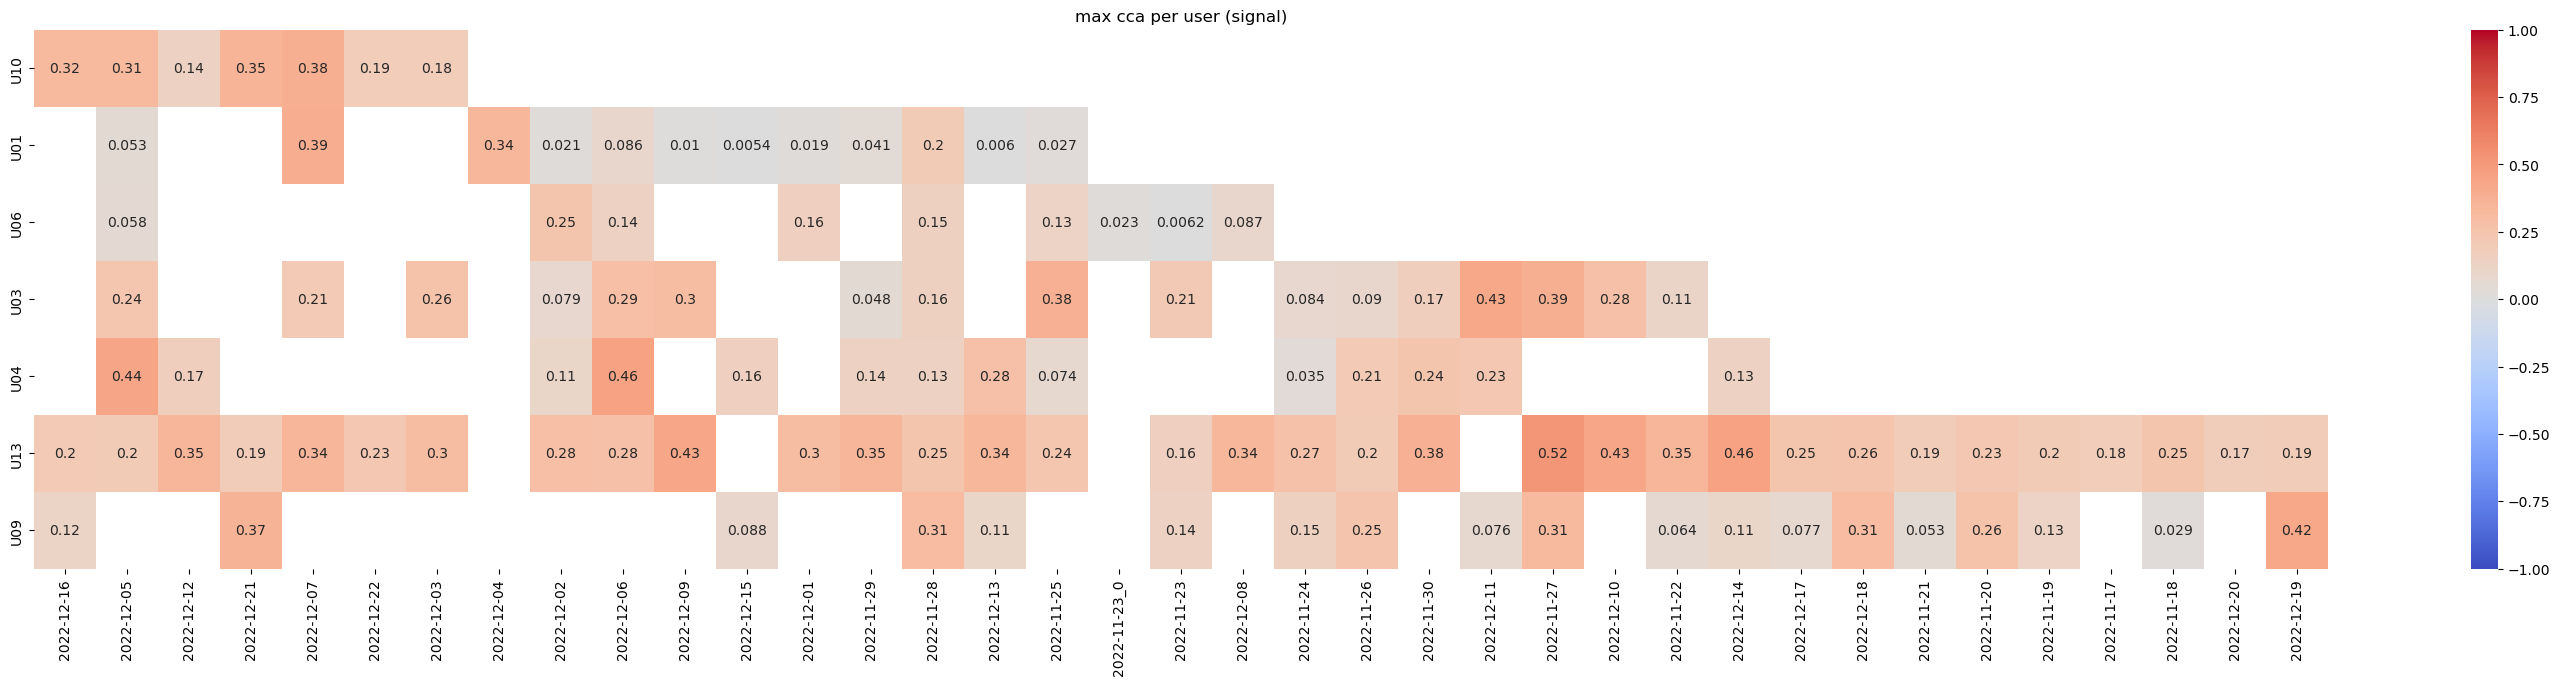

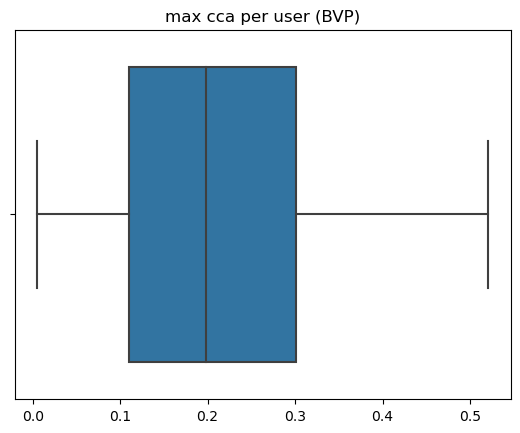

In [9]:
## BVP
signal: str = "BVP"
time_scale: int = 20
dcca = perform_correlation(
    physiological_data=new_physiological_data,
    signal=signal,
    time_scale=time_scale,
    detrended=False,
    measure_name="max dcca",
    data_name='mwc2022',
    n_jobs=-1,
)

from numpy import mean
max_dccas = {
    user: {
        session_name: max(session_dcca) if len(session_dcca) > 0 else nan
        for session_name, session_dcca in user_dcca.items()
    }
    for user, user_dcca in dcca.items()
}
avg_max_dccas = {
    user: mean(max_dcca)
    for user, user_dcca in max_dccas.items()
    for session_name, max_dcca in user_dcca.items()
}
from seaborn import heatmap, boxplot
from matplotlib.pyplot import plot, savefig, show, style, figure, title

def plot_heatmap_boxplot(
    data: dict,
    signal: str,
    data_name: str = "",
    measure_name: str = "",
    nested: bool = False,
    **kwargs,
):
    if nested:
        # reform = {
        #     (outerKey, innerKey): values
        #     for outerKey, innerDict in data.items()
        #     for innerKey, values in innerDict.items()
        # }
        # df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
        df_to_save = DataFrame(data).T
    else:
        df_to_save: Series = Series(data)
        
        df_to_save: DataFrame = (
            DataFrame(df_to_save, columns=[measure_name]).sort_index().T
        )

    figure(figsize=(len(df_to_save.columns), len(df_to_save.index)))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=kwargs.get("vmax", 1),
        vmin=kwargs.get("vmin", -1),
        center=kwargs.get("center", 0),
        cmap=kwargs.get("cmap", "coolwarm"),
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"{measure_name} per user (signal)")
    savefig(
        f"../visualizations/user_{measure_name}_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

    boxplot(x=df_to_save.values)
    title(f"{measure_name} per user ({signal})")
    savefig(
        f"../visualizations/user_{measure_name}_boxplot_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()


plot_heatmap_boxplot(
            data=max_dccas,
            signal=signal,
            measure_name="max cca",
            nested=True,
            vmax=1,
            vmin=-1,
            center=0,
            data_name="mwc2022",
        )

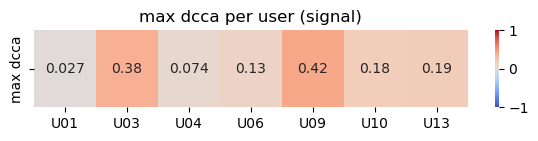

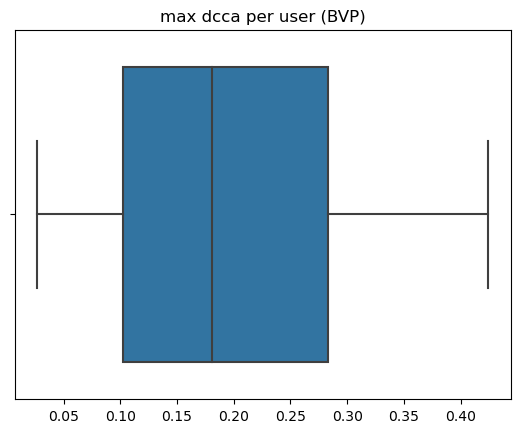

In [10]:
plot_heatmap_boxplot(
            data=avg_max_dccas,
            signal=signal,
            measure_name="max dcca",
            nested=False,
            vmax=1,
            vmin=-1,
            center=0,
            data_name="mwc2022",
        )

# Dynamic Time Warping

In [136]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sys import path
path.append("../")
from src.utils.plots import plot_heatmap_boxplot

In [172]:
def run_dtw_calculation(
    physiological_data: dict, signal: str, n_jobs: int = -1, **kwargs
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))

    # Define a function that takes in a user and computes the DTW distance
    def compute_dtw(user, physiological_data, signal, session_name):
        x = (
            physiological_data[signal]["right"][user][session_name]
            .values.reshape(-1, 1)
        )
        y = (
            physiological_data[signal]["left"][user][session_name]
            .values.reshape(-1, 1)
        )
        return user, session_name, fastdtw(x=x, y=y, dist=kwargs.get("distance", euclidean))[0]

    # Use Parallel and delayed to run the function in parallel
    dtws = Parallel(n_jobs=n_jobs)(
        delayed(compute_dtw)(user, physiological_data, signal, session_name)
        for user in tqdm(user_list, desc="User progress", colour="blue")
        for session_name in tqdm(list(
            set(physiological_data[signal]["right"][user].keys())
            & set(physiological_data[signal]["left"][user].keys())
        ), desc='Session progress', colour='green')
    )

    # Convert the results to a dictionary
    return dtws


## EDA

In [173]:
signal: str = "EDA"
dtws = run_dtw_calculation(
    physiological_data=new_physiological_data, signal=signal, n_jobs=-1
)


User progress:   0%|          | 0/7 [00:00<?, ?it/s]

Session progress:   0%|          | 0/33 [00:00<?, ?it/s]

Session progress:   0%|          | 0/7 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Session progress:   0%|          | 0/12 [00:00<?, ?it/s]

Session progress:   0%|          | 0/19 [00:00<?, ?it/s]

Session progress:   0%|          | 0/14 [00:00<?, ?it/s]

Session progress:   0%|          | 0/8 [00:00<?, ?it/s]

Session progress:   0%|          | 0/17 [00:00<?, ?it/s]

In [193]:
from seaborn import heatmap, boxplot
from matplotlib.pyplot import plot, savefig, show, style, figure, title

def plot_heatmap_boxplot(
    data: dict,
    signal: str,
    data_name: str = "",
    measure_name: str = "",
    nested: bool = False,
    **kwargs,
):
    if nested:
        # reform = {
        #     (outerKey, innerKey): values
        #     for outerKey, innerDict in data.items()
        #     for innerKey, values in innerDict.items()
        # }
        # df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
        df_to_save = DataFrame(data).T
    else:
        df_to_save: Series = Series(data)
        
        df_to_save: DataFrame = (
            DataFrame(df_to_save, columns=[measure_name]).sort_index().T
        )

    figure(figsize=(len(df_to_save.columns), len(df_to_save.index)))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=kwargs.get("vmax", 1),
        vmin=kwargs.get("vmin", -1),
        center=kwargs.get("center", 0),
        cmap=kwargs.get("cmap", "coolwarm"),
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"{measure_name} per user (signal)")
    savefig(
        f"../visualizations/user_{measure_name}_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

    boxplot(x=df_to_save.values)
    title(f"{measure_name} per user ({signal})")
    savefig(
        f"../visualizations/user_{measure_name}_boxplot_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

new_dtws = defaultdict(dict)
for user, session_name, dtw in dtws:
    new_dtws[user][session_name] = dtw

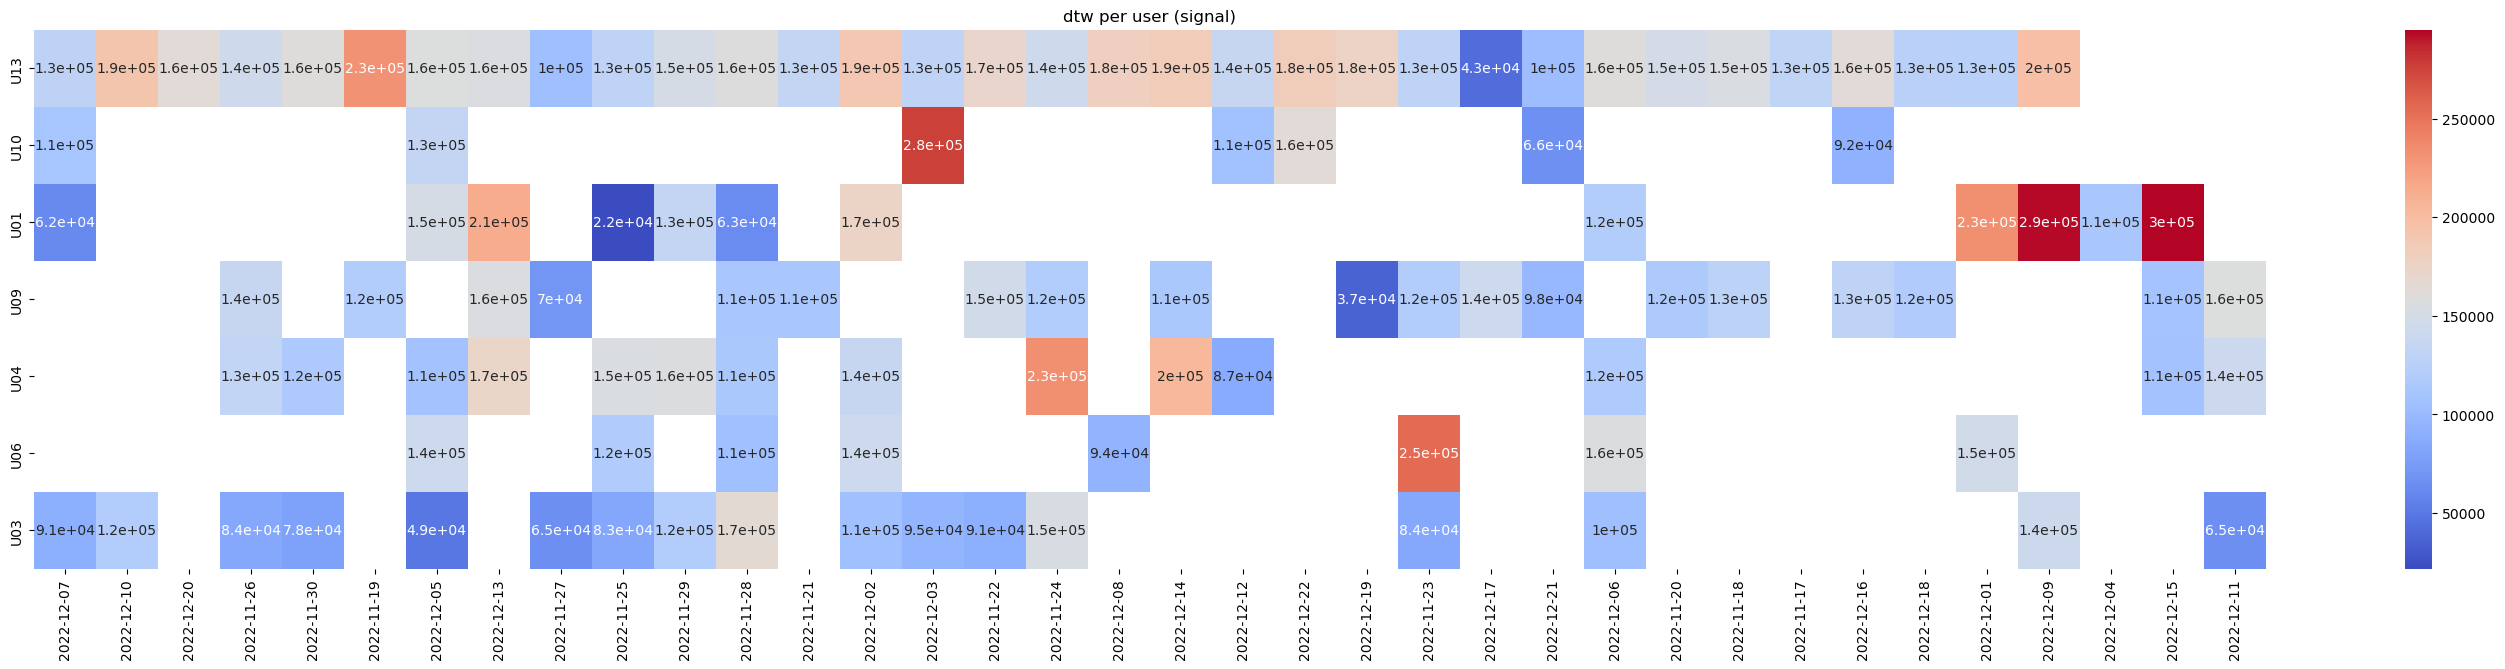

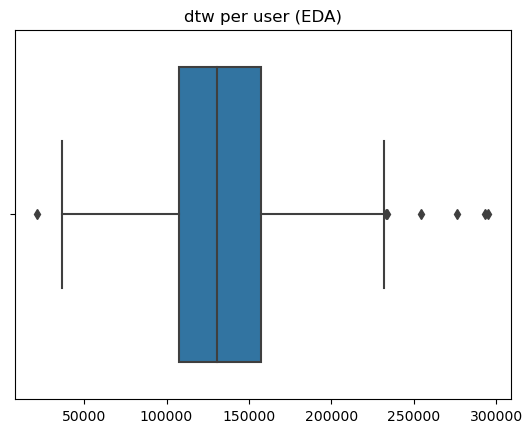

In [182]:


plot_heatmap_boxplot(
            data=new_dtws,
            signal=signal,
            measure_name="dtw",
            nested=True,
            vmax=None,
            vmin=None,
            center=None,
            data_name="mwc2022",
        )

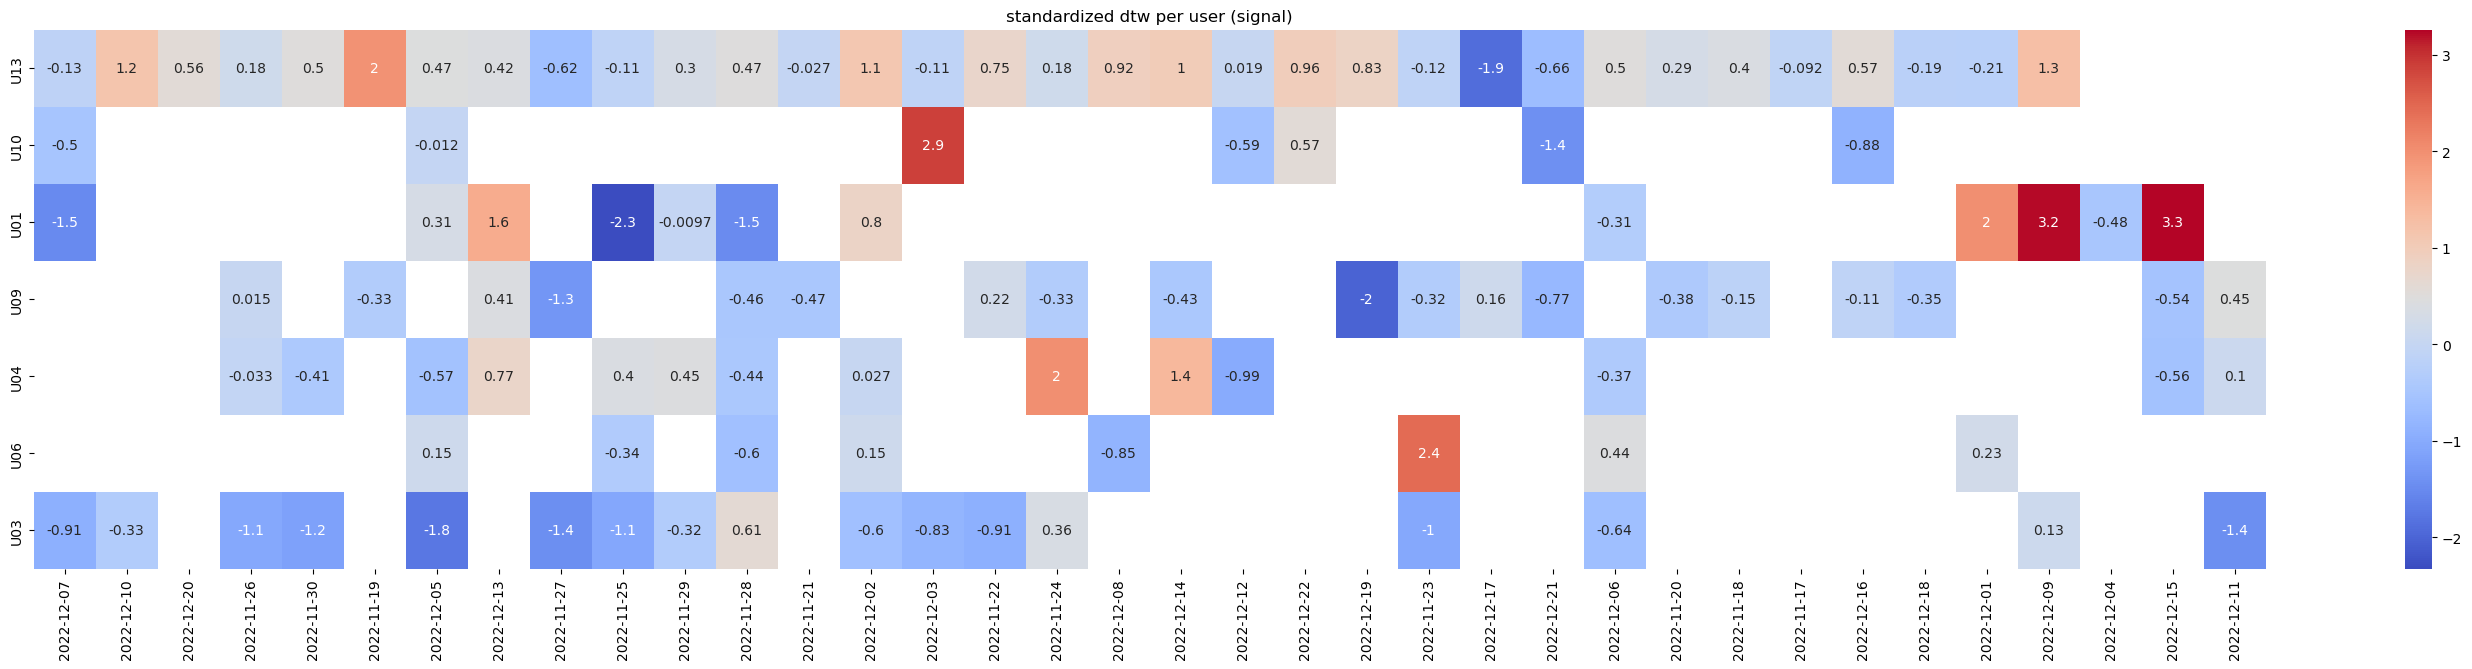

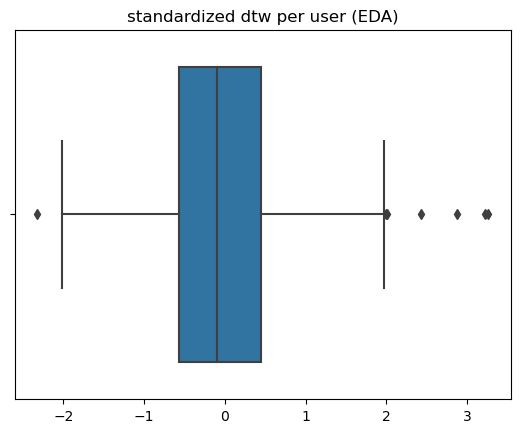

In [187]:
from numpy import nanmean, nanstd

dtws_new_stand = {
    user: {
        session: (
            session_data
            - nanmean(
                [el for user_data in new_dtws.values() for el in user_data.values()]
            )
        )
        / nanstd([el for user_data in new_dtws.values() for el in user_data.values()])
        for session, session_data in user_data.items()
    }
    for user, user_data in new_dtws.items()
}

plot_heatmap_boxplot(
    data=dtws_new_stand,
    signal=signal,
    measure_name="standardized dtw",
    nested=True,
    vmax=None,
    vmin=None,
    center=None,
    data_name="mwc2022",
)


In [192]:
nanmean(list(new_dtws['U01'].values()))

156168.24717230056

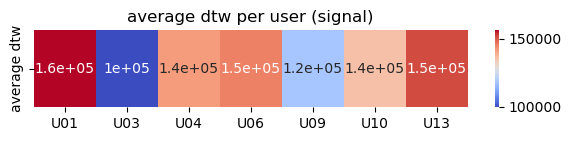

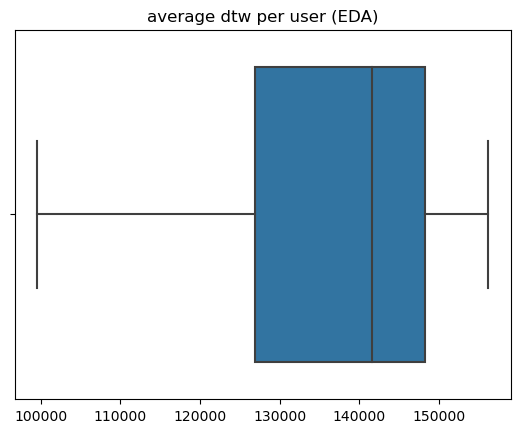

In [196]:
avgs_dtsw = {user: nanmean(list(user_data.values())) for user, user_data in new_dtws.items()}

plot_heatmap_boxplot(
            data=avgs_dtsw,
            signal=signal,
            measure_name="average dtw",
            nested=False,
            vmax=None,
            vmin=None,
            center=None,
            data_name="mwc2022",
        )

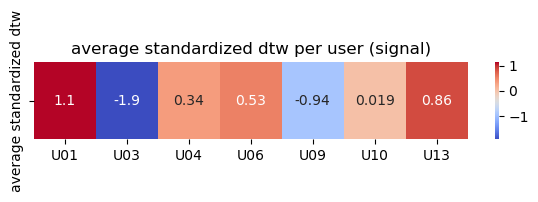

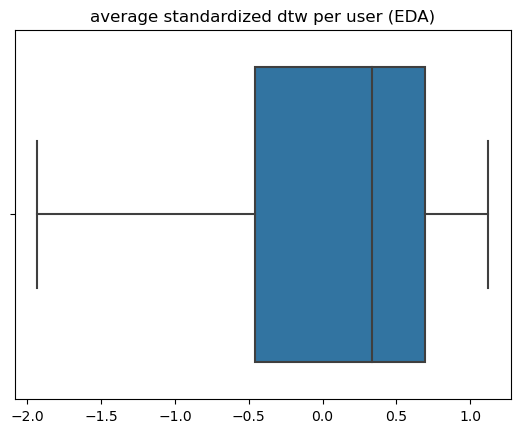

In [198]:
avg_stand_dtw = {
    user: (user_data - nanmean(list(avgs_dtsw.values())))/nanstd(list(avgs_dtsw.values()))
    for user, user_data in avgs_dtsw.items()
}

plot_heatmap_boxplot(
            data=avg_stand_dtw,
            signal=signal,
            measure_name="average standardized dtw",
            nested=False,
            vmax=None,
            vmin=None,
            center=None,
            data_name="mwc2022",
        )

## BVP

In [199]:
signal: str = "BVP"
dtws = run_dtw_calculation(
    physiological_data=new_physiological_data, signal=signal, n_jobs=-1
)


User progress:   0%|          | 0/6 [00:00<?, ?it/s]

Session progress:   0%|          | 0/33 [00:00<?, ?it/s]

Session progress:   0%|          | 0/7 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Session progress:   0%|          | 0/12 [00:00<?, ?it/s]

Session progress:   0%|          | 0/19 [00:00<?, ?it/s]

Session progress:   0%|          | 0/9 [00:00<?, ?it/s]

Session progress:   0%|          | 0/17 [00:00<?, ?it/s]

In [200]:
from seaborn import heatmap, boxplot
from matplotlib.pyplot import plot, savefig, show, style, figure, title

def plot_heatmap_boxplot(
    data: dict,
    signal: str,
    data_name: str = "",
    measure_name: str = "",
    nested: bool = False,
    **kwargs,
):
    if nested:
        # reform = {
        #     (outerKey, innerKey): values
        #     for outerKey, innerDict in data.items()
        #     for innerKey, values in innerDict.items()
        # }
        # df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
        df_to_save = DataFrame(data).T
    else:
        df_to_save: Series = Series(data)
        
        df_to_save: DataFrame = (
            DataFrame(df_to_save, columns=[measure_name]).sort_index().T
        )

    figure(figsize=(len(df_to_save.columns), len(df_to_save.index)))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=kwargs.get("vmax", 1),
        vmin=kwargs.get("vmin", -1),
        center=kwargs.get("center", 0),
        cmap=kwargs.get("cmap", "coolwarm"),
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"{measure_name} per user (signal)")
    savefig(
        f"../visualizations/user_{measure_name}_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

    boxplot(x=df_to_save.values)
    title(f"{measure_name} per user ({signal})")
    savefig(
        f"../visualizations/user_{measure_name}_boxplot_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

new_dtws = defaultdict(dict)
for user, session_name, dtw in dtws:
    new_dtws[user][session_name] = dtw

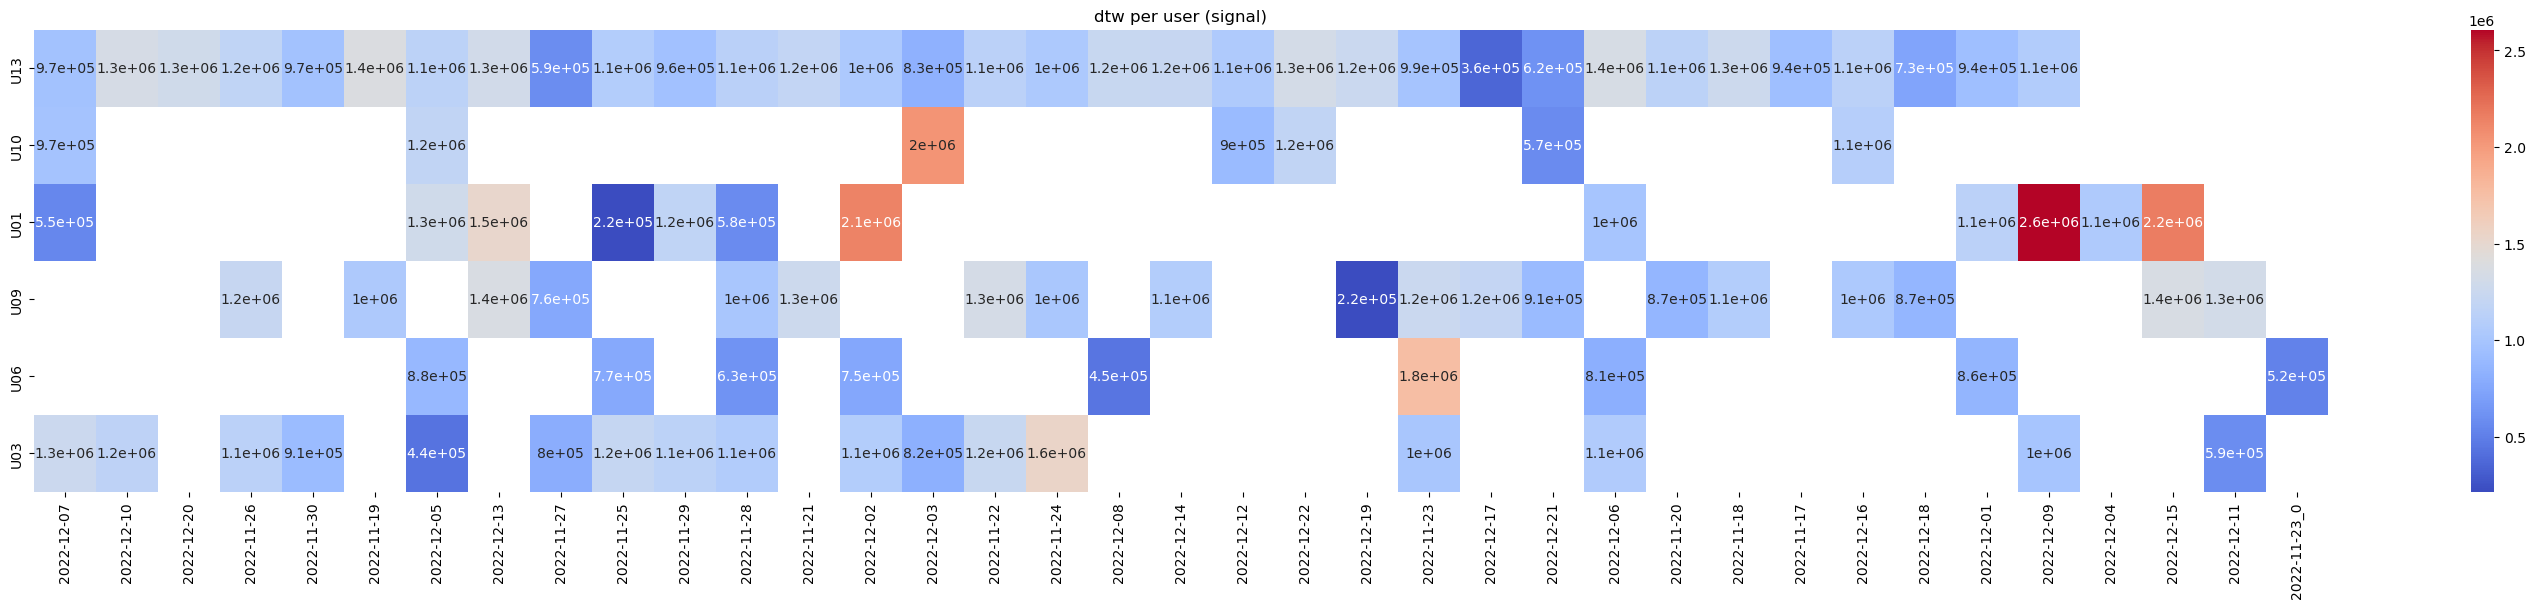

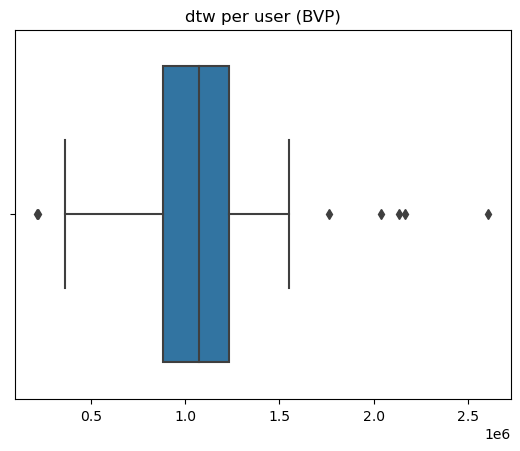

In [201]:


plot_heatmap_boxplot(
            data=new_dtws,
            signal=signal,
            measure_name="dtw",
            nested=True,
            vmax=None,
            vmin=None,
            center=None,
            data_name="mwc2022",
        )

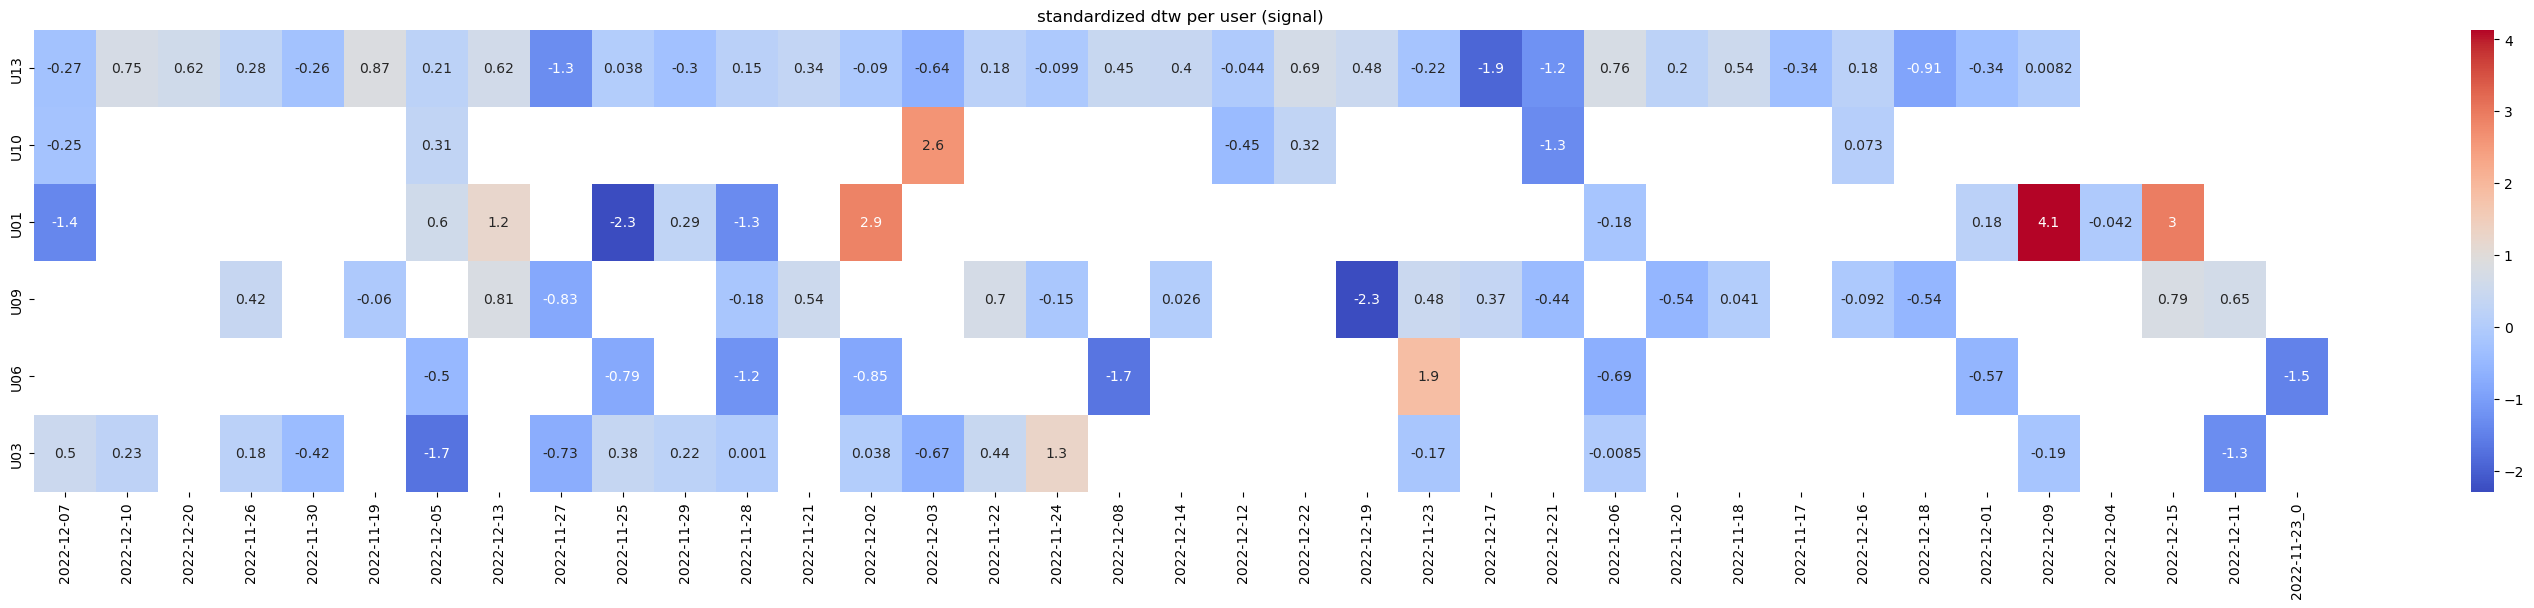

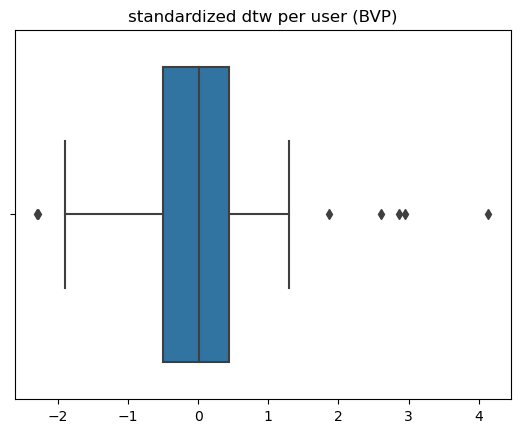

In [202]:
from numpy import nanmean, nanstd

dtws_new_stand = {
    user: {
        session: (
            session_data
            - nanmean(
                [el for user_data in new_dtws.values() for el in user_data.values()]
            )
        )
        / nanstd([el for user_data in new_dtws.values() for el in user_data.values()])
        for session, session_data in user_data.items()
    }
    for user, user_data in new_dtws.items()
}

plot_heatmap_boxplot(
    data=dtws_new_stand,
    signal=signal,
    measure_name="standardized dtw",
    nested=True,
    vmax=None,
    vmin=None,
    center=None,
    data_name="mwc2022",
)


In [ ]:
nanmean(list(new_dtws['U01'].values()))

156168.24717230056

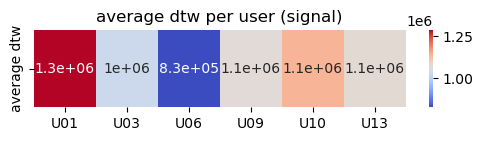

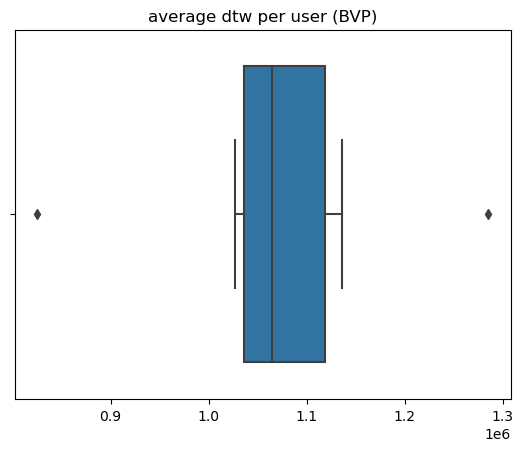

In [203]:
avgs_dtsw = {user: nanmean(list(user_data.values())) for user, user_data in new_dtws.items()}

plot_heatmap_boxplot(
            data=avgs_dtsw,
            signal=signal,
            measure_name="average dtw",
            nested=False,
            vmax=None,
            vmin=None,
            center=None,
            data_name="mwc2022",
        )

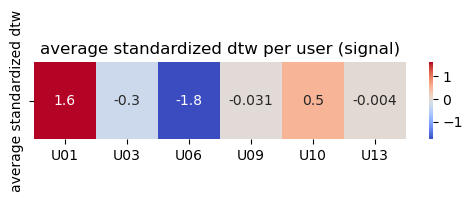

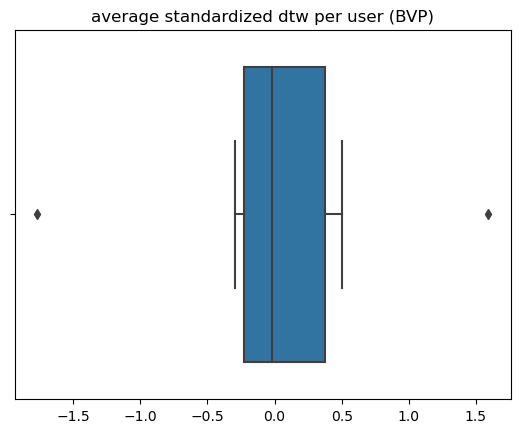

In [204]:
avg_stand_dtw = {
    user: (user_data - nanmean(list(avgs_dtsw.values())))/nanstd(list(avgs_dtsw.values()))
    for user, user_data in avgs_dtsw.items()
}

plot_heatmap_boxplot(
            data=avg_stand_dtw,
            signal=signal,
            measure_name="average standardized dtw",
            nested=False,
            vmax=None,
            vmin=None,
            center=None,
            data_name="mwc2022",
        )

# Weighted Dynamic Time Warping

In [5]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sys import path
path.append("../")
from src.utils.plots import plot_heatmap_boxplot

In [25]:
def run_dtw_calculation(
    physiological_data: dict, signal: str, n_jobs: int = -1, **kwargs
):
    users_left = physiological_data[signal]["left"].keys()
    users_right = physiological_data[signal]["right"].keys()
    user_list = list(set(users_left) & set(users_right))

    # Define a function that takes in a user and computes the DTW distance
    def compute_dtw(user, physiological_data, signal, session_name):
        x = (
            physiological_data[signal]["right"][user][session_name]
            .values.reshape(-1, 1)
        )
        y = (
            physiological_data[signal]["left"][user][session_name]
            .values.reshape(-1, 1)
        )
        return user, session_name, fastdtw(x=x, y=y, dist=kwargs.get("distance", euclidean))[0]/(len(x) if len(x) > 0 else 1)

    # Use Parallel and delayed to run the function in parallel
    dtws = Parallel(n_jobs=n_jobs)(
        delayed(compute_dtw)(user, physiological_data, signal, session_name)
        for user in tqdm(user_list, desc="User progress", colour="blue")
        for session_name in tqdm(list(
            set(physiological_data[signal]["right"][user].keys())
            & set(physiological_data[signal]["left"][user].keys())
        ), desc='Session progress', colour='green')
    )

    # Convert the results to a dictionary
    return dtws


## EDA

In [7]:
signal: str = "EDA"
dtws = run_dtw_calculation(
    physiological_data=new_physiological_data, signal=signal, n_jobs=-1
)


User progress:   0%|          | 0/7 [00:00<?, ?it/s]

Session progress:   0%|          | 0/33 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Session progress:   0%|          | 0/17 [00:00<?, ?it/s]

Session progress:   0%|          | 0/7 [00:00<?, ?it/s]

Session progress:   0%|          | 0/19 [00:00<?, ?it/s]

Session progress:   0%|          | 0/8 [00:00<?, ?it/s]

Session progress:   0%|          | 0/12 [00:00<?, ?it/s]

Session progress:   0%|          | 0/14 [00:00<?, ?it/s]

In [8]:
from seaborn import heatmap, boxplot
from matplotlib.pyplot import plot, savefig, show, style, figure, title

def plot_heatmap_boxplot(
    data: dict,
    signal: str,
    data_name: str = "",
    measure_name: str = "",
    nested: bool = False,
    **kwargs,
):
    if nested:
        # reform = {
        #     (outerKey, innerKey): values
        #     for outerKey, innerDict in data.items()
        #     for innerKey, values in innerDict.items()
        # }
        # df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
        df_to_save = DataFrame(data).sort_index().T
    else:
        df_to_save: Series = Series(data)
        
        df_to_save: DataFrame = (
            DataFrame(df_to_save, columns=[measure_name]).sort_index().T
        )

    figure(figsize=(len(df_to_save.columns), len(df_to_save.index)))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=kwargs.get("vmax", 1),
        vmin=kwargs.get("vmin", -1),
        center=kwargs.get("center", 0),
        cmap=kwargs.get("cmap", "coolwarm"),
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"{measure_name} per user (signal)")
    savefig(
        f"../visualizations/user_{measure_name}_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

    boxplot(x=df_to_save.values)
    title(f"{measure_name} per user ({signal})")
    savefig(
        f"../visualizations/user_{measure_name}_boxplot_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

new_dtws = defaultdict(dict)
for user, session_name, dtw in dtws:
    new_dtws[user][session_name] = dtw

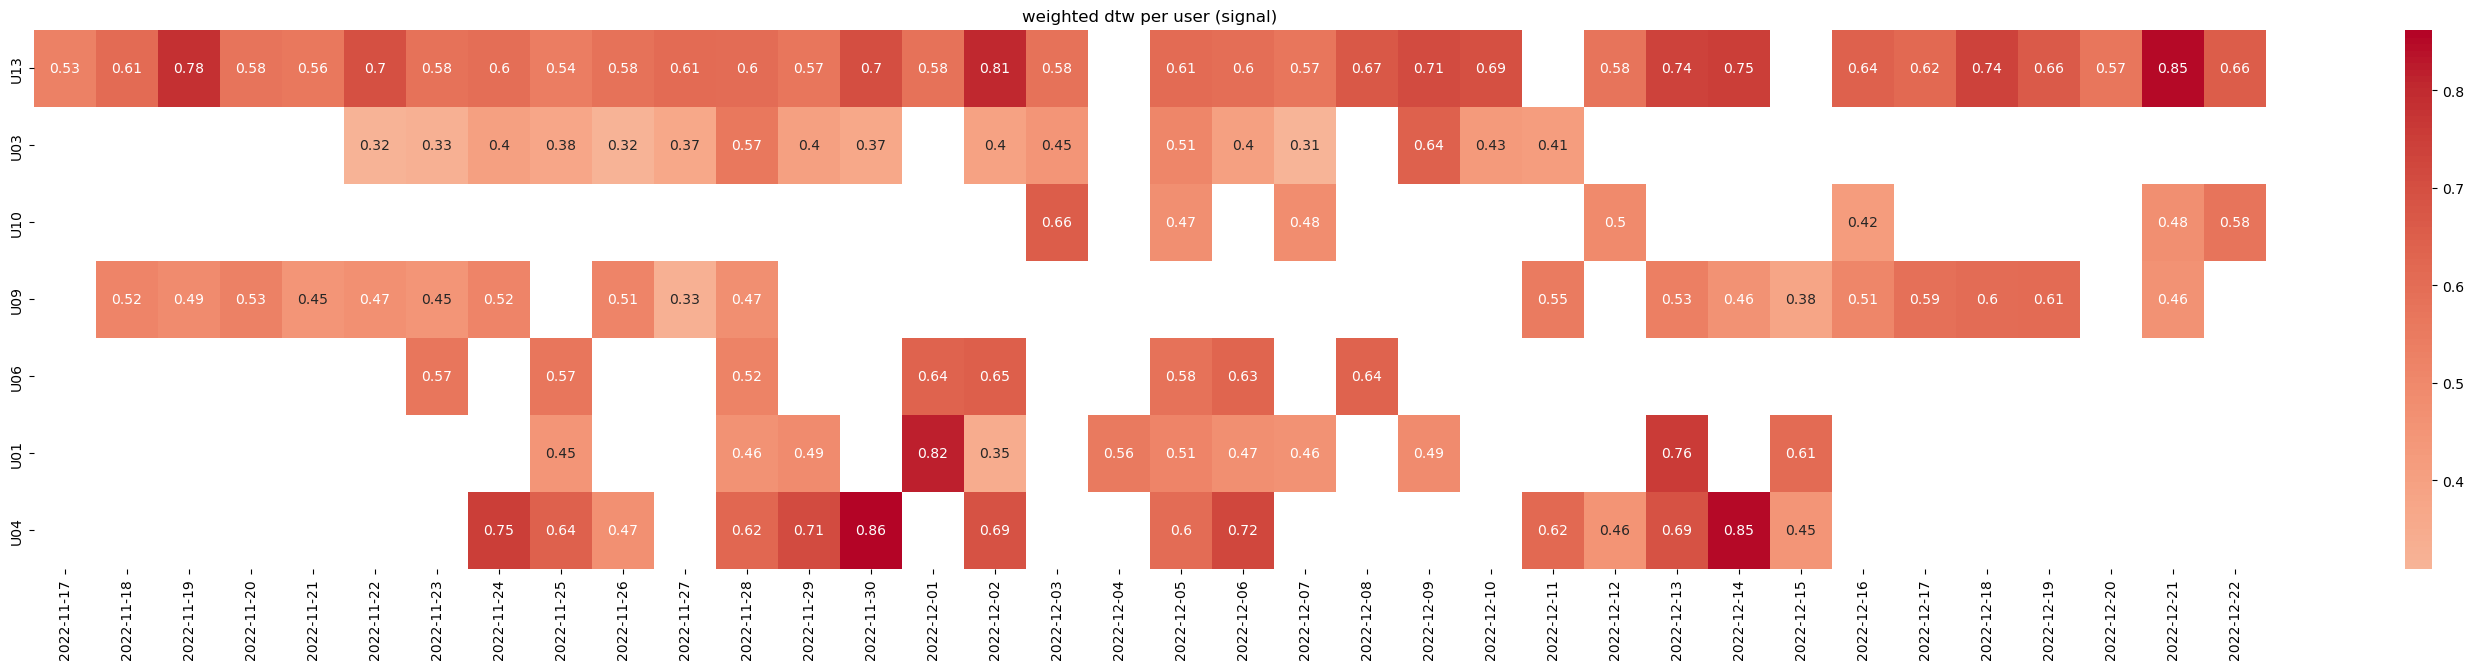

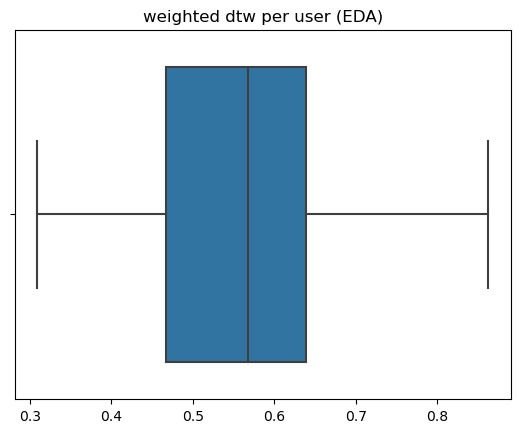

In [24]:


plot_heatmap_boxplot(
            data=new_dtws,
            signal=signal,
            measure_name="weighted dtw",
            nested=True,
            vmax=None,
            vmin=None,
            center=0,
            data_name="mwc2022",
        )

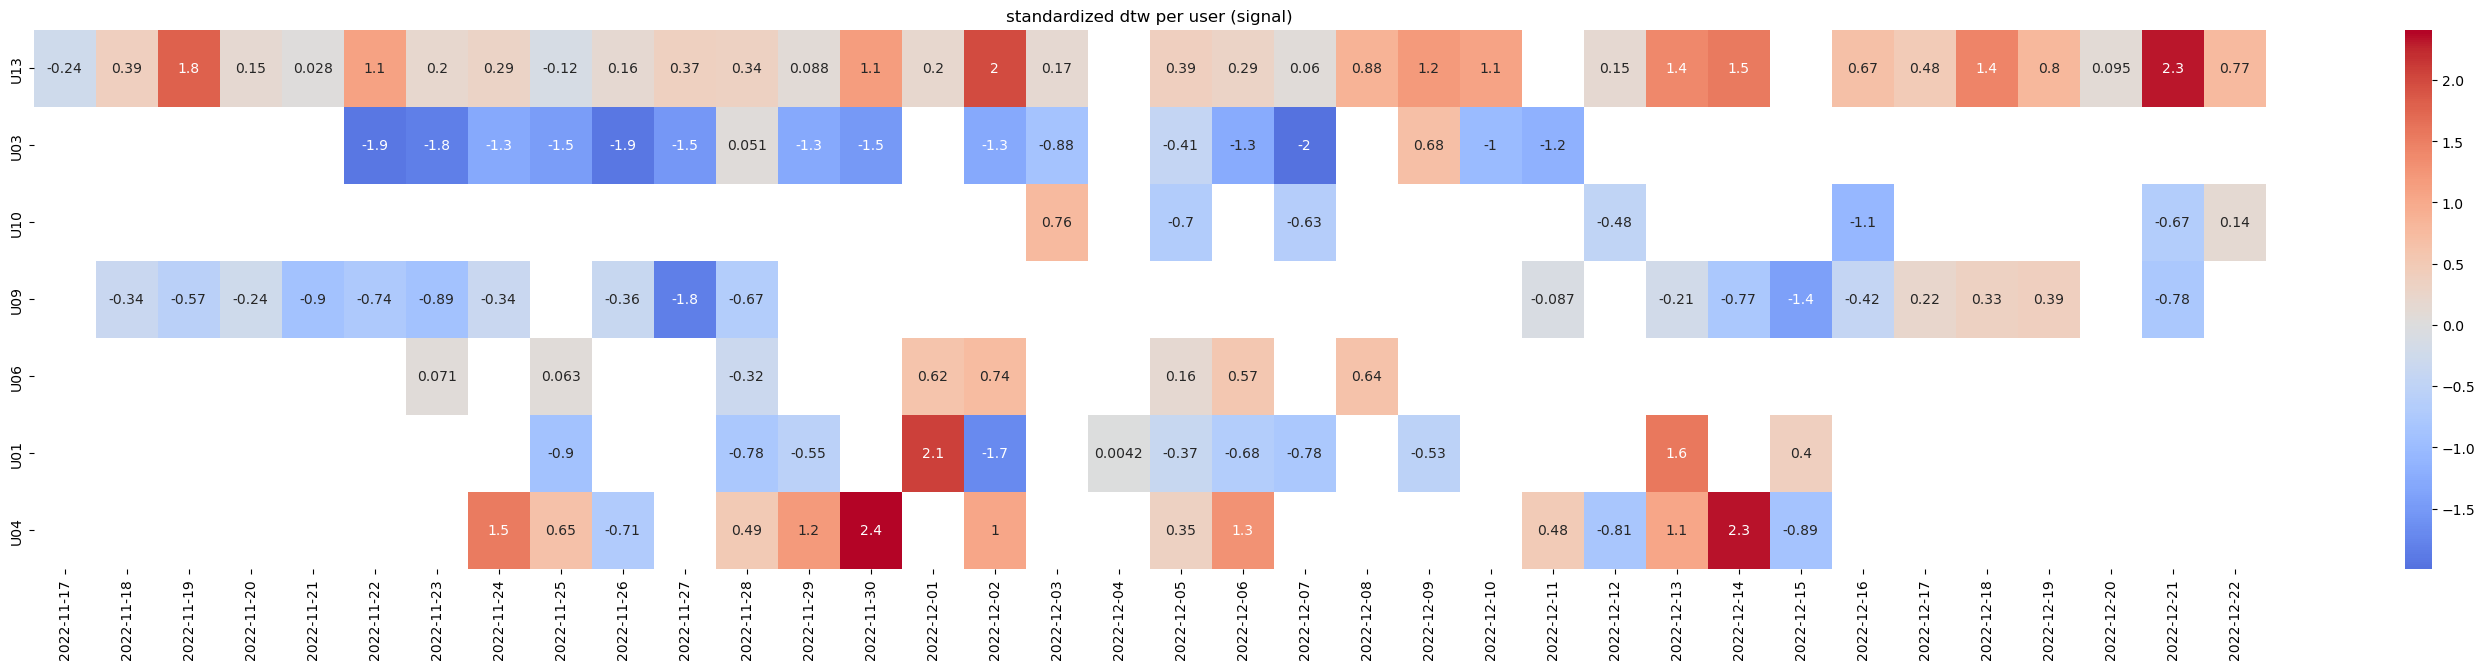

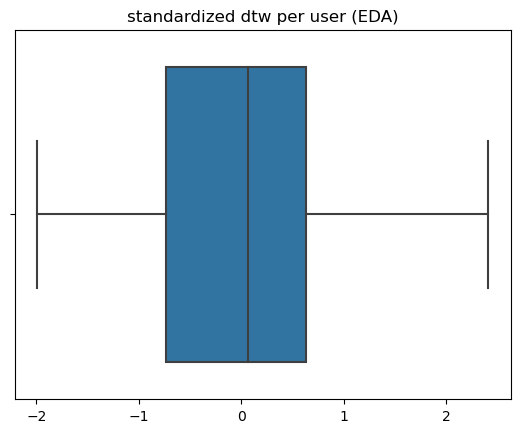

In [16]:
from numpy import nanmean, nanstd

dtws_new_stand = {
    user: {
        session: (
            session_data
            - nanmean(
                [el for user_data in new_dtws.values() for el in user_data.values()]
            )
        )
        / nanstd([el for user_data in new_dtws.values() for el in user_data.values()])
        for session, session_data in user_data.items()
    }
    for user, user_data in new_dtws.items()
}

plot_heatmap_boxplot(
    data=dtws_new_stand,
    signal=signal,
    measure_name="standardized dtw",
    nested=True,
    vmax=None,
    vmin=None,
    center=0,
    data_name="mwc2022",
)


In [20]:
from numpy import nanmean
avgs_dtsw = {user: nanmean(list(user_data.values())) for user, user_data in new_dtws.items()}

plot_heatmap_boxplot(
            data=avgs_dtsw,
            signal=signal,
            measure_name="average weighted dtw",
            nested=False,
            vmax=None,
            vmin=None,
            center=0,
            data_name="mwc2022",
        )

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

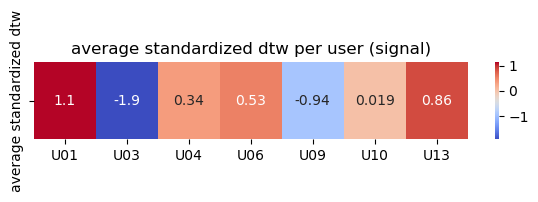

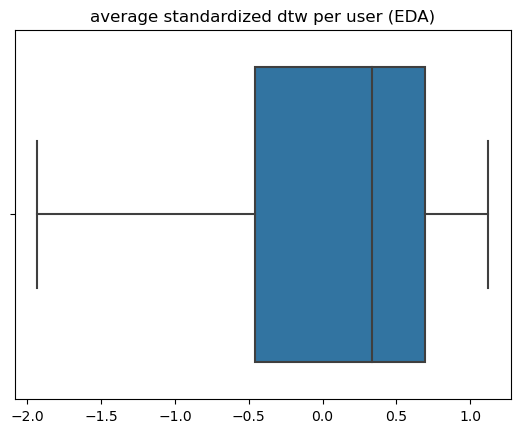

In [ ]:
avg_stand_dtw = {
    user: (user_data - nanmean(list(avgs_dtsw.values())))/nanstd(list(avgs_dtsw.values()))
    for user, user_data in avgs_dtsw.items()
}

plot_heatmap_boxplot(
            data=avg_stand_dtw,
            signal=signal,
            measure_name="average standardized dtw",
            nested=False,
            vmax=None,
            vmin=None,
            center=None,
            data_name="mwc2022",
        )

## BVP

In [26]:
signal: str = "BVP"
dtws = run_dtw_calculation(
    physiological_data=new_physiological_data, signal=signal, n_jobs=-1
)


User progress:   0%|          | 0/7 [00:00<?, ?it/s]

Session progress:   0%|          | 0/33 [00:00<?, ?it/s]

Session progress:   0%|          | 0/17 [00:00<?, ?it/s]

/Users/leonardoalchieri/miniconda3/envs/laugh2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Session progress:   0%|          | 0/7 [00:00<?, ?it/s]

Session progress:   0%|          | 0/19 [00:00<?, ?it/s]

Session progress:   0%|          | 0/9 [00:00<?, ?it/s]

Session progress:   0%|          | 0/12 [00:00<?, ?it/s]

Session progress:   0%|          | 0/14 [00:00<?, ?it/s]

In [27]:
from seaborn import heatmap, boxplot
from matplotlib.pyplot import plot, savefig, show, style, figure, title

def plot_heatmap_boxplot(
    data: dict,
    signal: str,
    data_name: str = "",
    measure_name: str = "",
    nested: bool = False,
    **kwargs,
):
    if nested:
        # reform = {
        #     (outerKey, innerKey): values
        #     for outerKey, innerDict in data.items()
        #     for innerKey, values in innerDict.items()
        # }
        # df_to_save = DataFrame.from_dict(reform).stack(level=1, dropna=False).T
        df_to_save = DataFrame(data).sort_index().T
    else:
        df_to_save: Series = Series(data)
        
        df_to_save: DataFrame = (
            DataFrame(df_to_save, columns=[measure_name]).sort_index().T
        )

    figure(figsize=(len(df_to_save.columns), len(df_to_save.index)))
    heatmap(
        df_to_save,
        xticklabels=df_to_save.columns,
        vmax=kwargs.get("vmax", 1),
        vmin=kwargs.get("vmin", -1),
        center=kwargs.get("center", 0),
        cmap=kwargs.get("cmap", "coolwarm"),
        yticklabels=df_to_save.index,
        annot=True,
    )
    title(f"{measure_name} per user (signal)")
    savefig(
        f"../visualizations/user_{measure_name}_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

    boxplot(x=df_to_save.values)
    title(f"{measure_name} per user ({signal})")
    savefig(
        f"../visualizations/user_{measure_name}_boxplot_{signal}_{data_name}.pdf",
        bbox_inches="tight",
    )
    show()

new_dtws = defaultdict(dict)
for user, session_name, dtw in dtws:
    new_dtws[user][session_name] = dtw

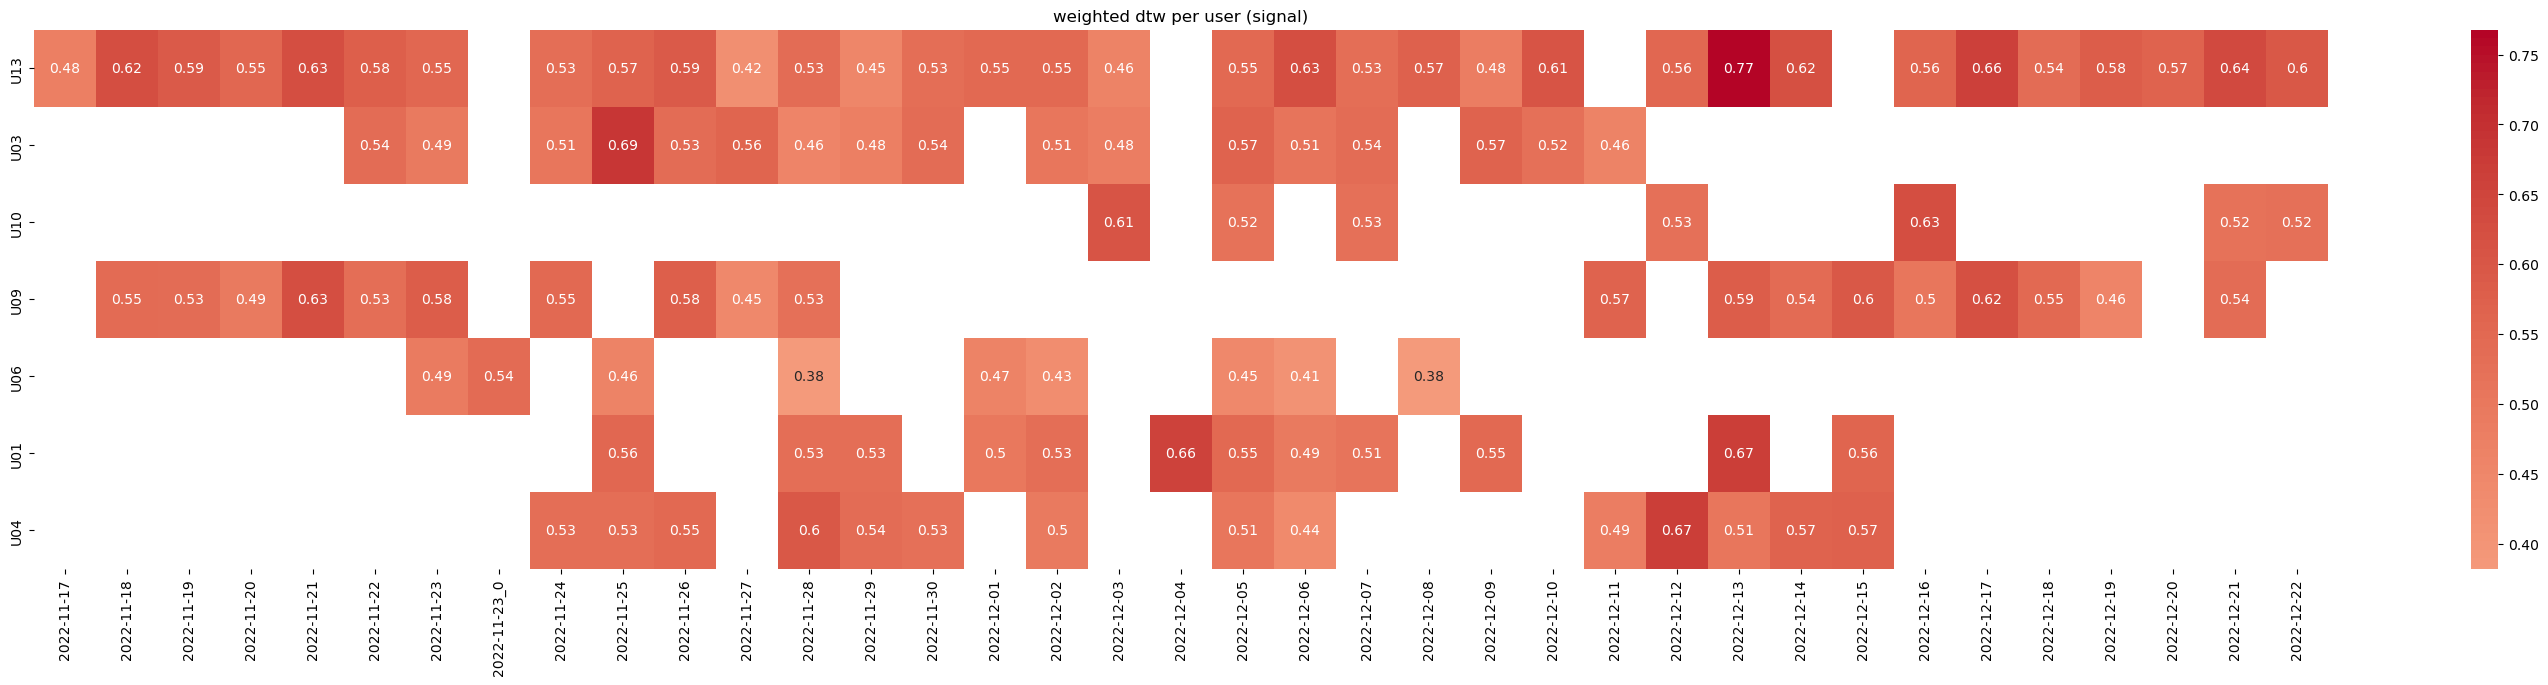

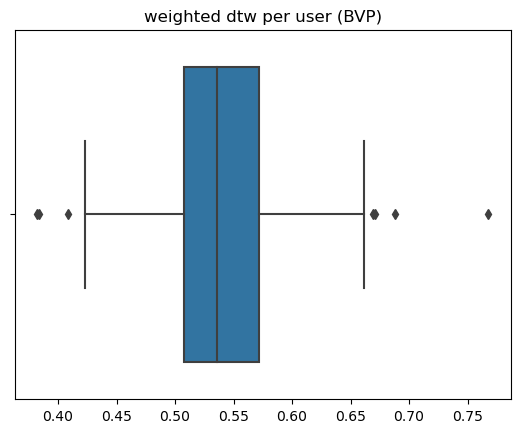

In [28]:
plot_heatmap_boxplot(
            data=new_dtws,
            signal=signal,
            measure_name="weighted dtw",
            nested=True,
            vmax=None,
            vmin=None,
            center=0,
            data_name="mwc2022",
        )

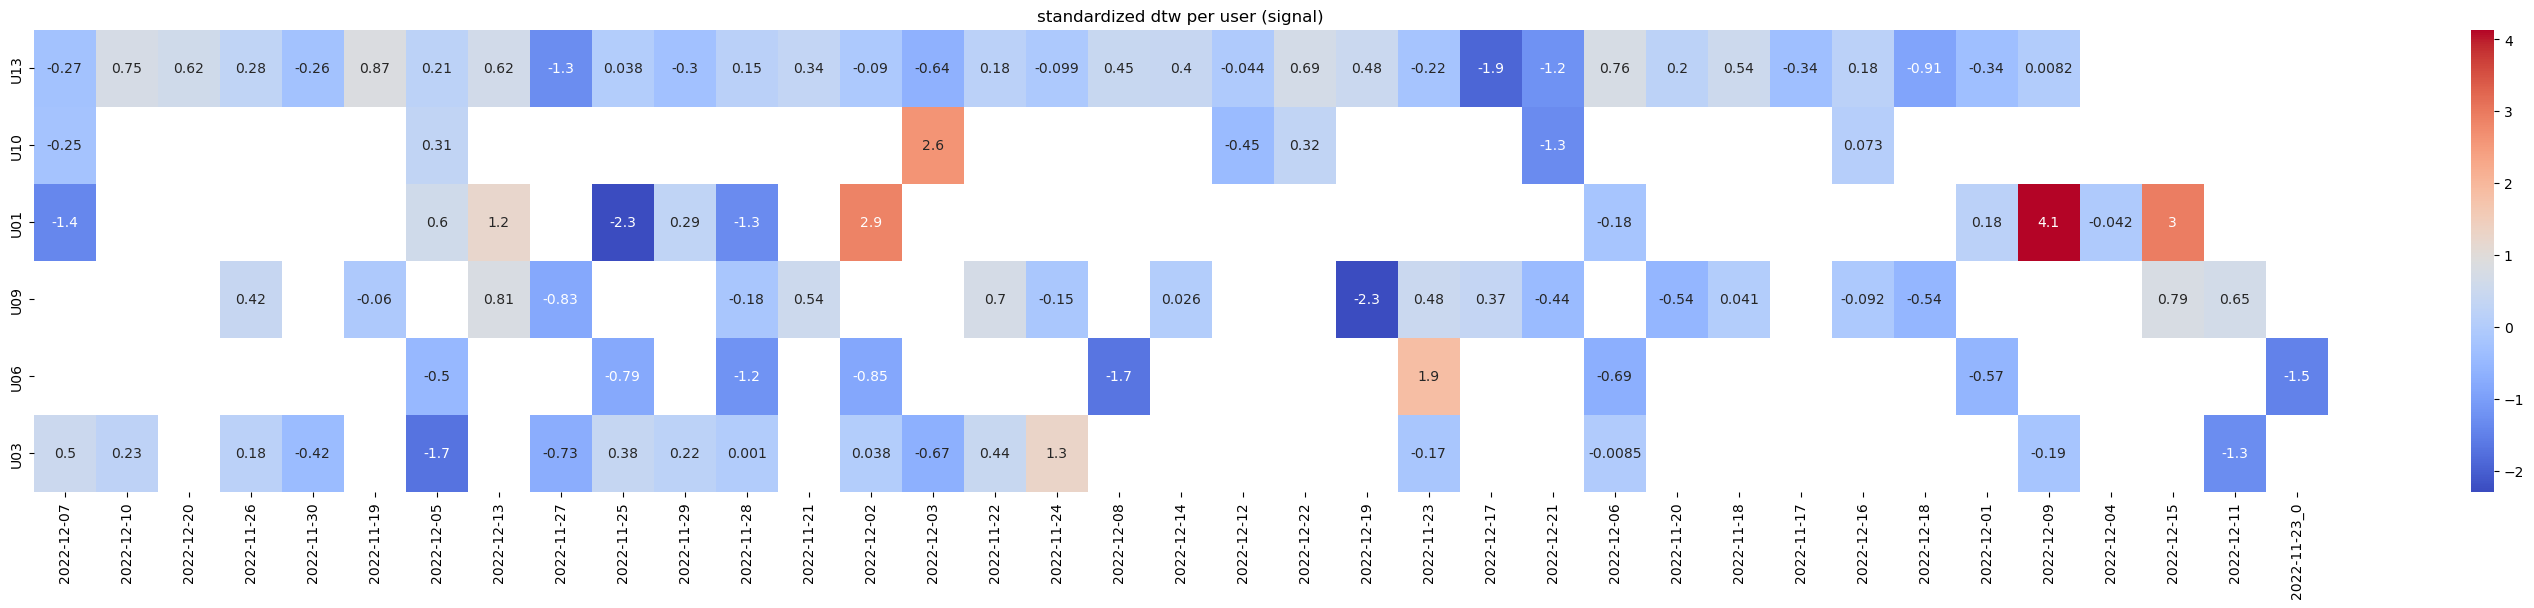

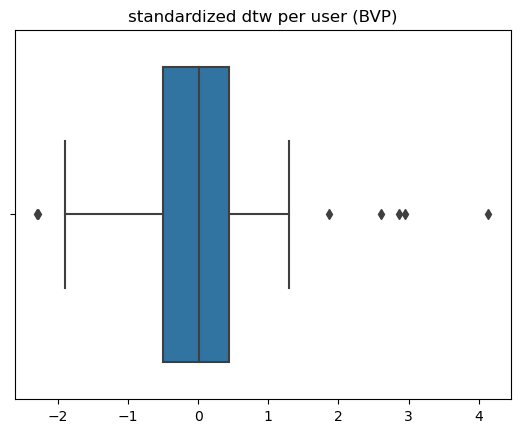

In [ ]:
from numpy import nanmean, nanstd

dtws_new_stand = {
    user: {
        session: (
            session_data
            - nanmean(
                [el for user_data in new_dtws.values() for el in user_data.values()]
            )
        )
        / nanstd([el for user_data in new_dtws.values() for el in user_data.values()])
        for session, session_data in user_data.items()
    }
    for user, user_data in new_dtws.items()
}

plot_heatmap_boxplot(
    data=dtws_new_stand,
    signal=signal,
    measure_name="standardized dtw",
    nested=True,
    vmax=None,
    vmin=None,
    center=None,
    data_name="mwc2022",
)


In [ ]:
nanmean(list(new_dtws['U01'].values()))

156168.24717230056

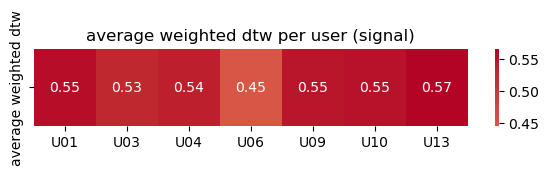

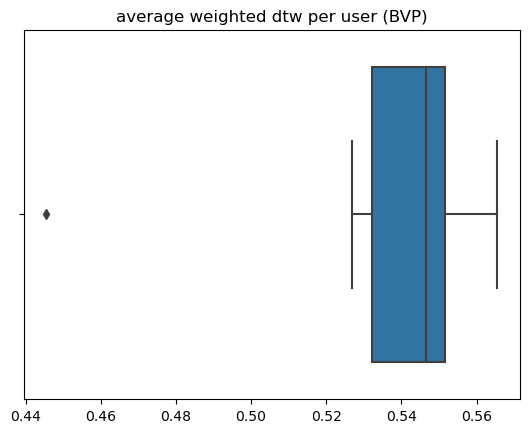

In [29]:
avgs_dtsw = {user: nanmean(list(user_data.values())) for user, user_data in new_dtws.items()}

plot_heatmap_boxplot(
            data=avgs_dtsw,
            signal=signal,
            measure_name="average weighted dtw",
            nested=False,
            vmax=None,
            vmin=None,
            center=0,
            data_name="mwc2022",
        )

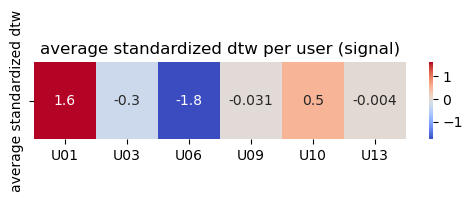

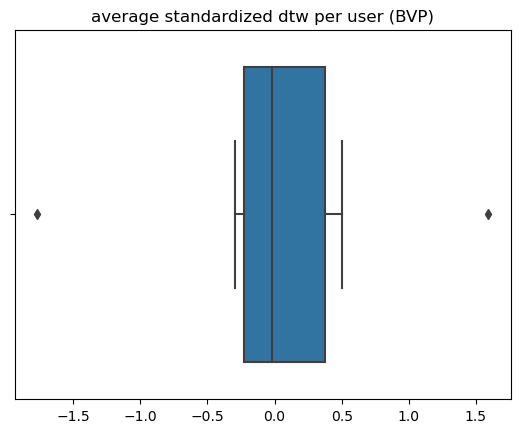

In [ ]:
avg_stand_dtw = {
    user: (user_data - nanmean(list(avgs_dtsw.values())))/nanstd(list(avgs_dtsw.values()))
    for user, user_data in avgs_dtsw.items()
}

plot_heatmap_boxplot(
            data=avg_stand_dtw,
            signal=signal,
            measure_name="average standardized dtw",
            nested=False,
            vmax=None,
            vmin=None,
            center=None,
            data_name="mwc2022",
        )

# Coherence Analysis

## EDA

In [9]:
from scipy.signal import coherence

In [60]:
signal: str = "EDA"
time_scale: int = 20
users_left = physiological_data[signal]["left"].keys()
users_right = physiological_data[signal]["right"].keys()
user_list = list(set(users_left) & set(users_right))

cas = {
    user: coherence(
        x=physiological_data[signal]["right"][user].iloc[:, 0].values,
        y=physiological_data[signal]["left"][user].iloc[:, 0].values,
        fs=1.,
        window='hann',
        nperseg=None,
        noverlap=None,
        nfft=None,
        detrend='constant',
        axis=-1,
    )
    for user in tqdm(user_list, desc="User progress", colour='blue')
}


User progress:   0%|          | 0/33 [00:00<?, ?it/s]

In [61]:
max_cca = {user: ca[1].max() for user, ca in cas.values() if len(ca[1]) > 0}

TypeError: object of type 'numpy.float64' has no len()

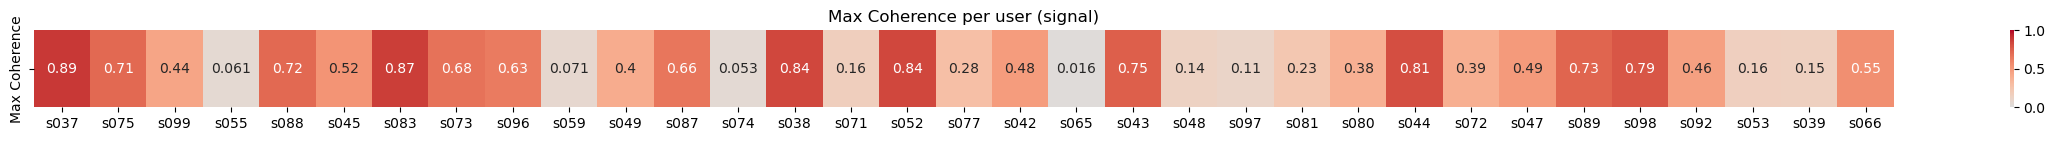

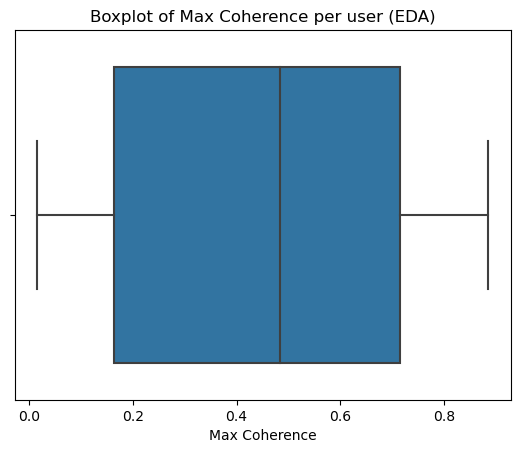

In [62]:
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap


df_to_save: Series = Series(max_cca)
df_to_save = DataFrame(df_to_save, columns=['Max Coherence']).T

figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    center=0,
    vmax=1,
    vmin=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title(f"Max Coherence per user (signal)")
savefig(f"../visualizations/user_max_cca_{signal}.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title(f"Boxplot of Max Coherence per user ({signal})")
savefig(f"../visualizations/user_max_cca_boxplot_{signal}.pdf", bbox_inches="tight")
show()


In [63]:
avg_cca = {user: ca[1].mean() for user, ca in cas.values() if len(ca[1]) > 0}

TypeError: object of type 'numpy.float64' has no len()

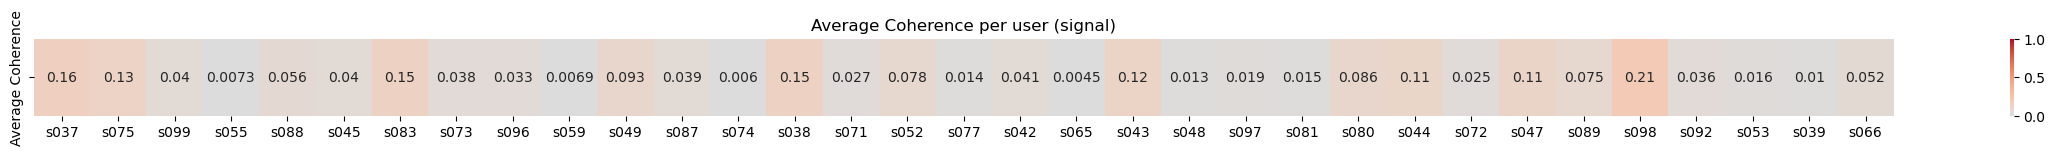

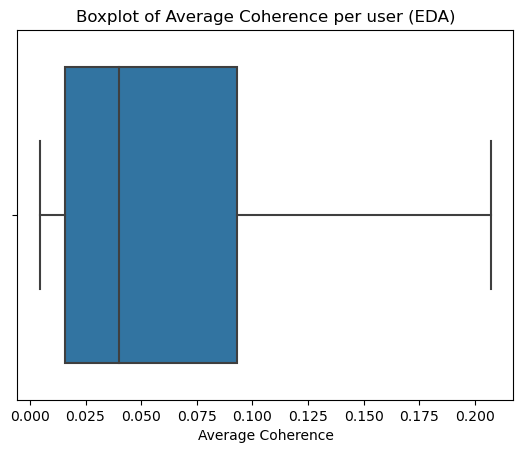

In [64]:
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap


df_to_save: Series = Series(avg_cca)
df_to_save = DataFrame(df_to_save, columns=['Average Coherence']).T

figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    vmax=1,
    vmin=0,
    center=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title(f"Average Coherence per user (signal)")
savefig(f"../visualizations/user_average_cca_{signal}.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title(f"Boxplot of Average Coherence per user ({signal})")
savefig(f"../visualizations/user_average_cca_boxplot_{signal}.pdf", bbox_inches="tight")
show()


## BVP

In [65]:
from scipy.signal import coherence

In [53]:
signal: str = "BVP"
time_scale: int = 20
users_left = physiological_data[signal]["left"].keys()
users_right = physiological_data[signal]["right"].keys()
user_list = list(set(users_left) & set(users_right))

cas = {
    user: coherence(
        x=physiological_data[signal]["right"][user].iloc[:, 0].values,
        y=physiological_data[signal]["left"][user].iloc[:, 0].values,
        fs=1.,
        window='hann',
        nperseg=None,
        noverlap=None,
        nfft=None,
        detrend='constant',
        axis=-1,
    )
    for user in tqdm(user_list, desc="User progress", colour='blue')
}


User progress:   0%|          | 0/34 [00:00<?, ?it/s]

In [54]:
max_cca = {user: ca[1].max() for user, ca in cas.items() if len(ca[1]) > 0}

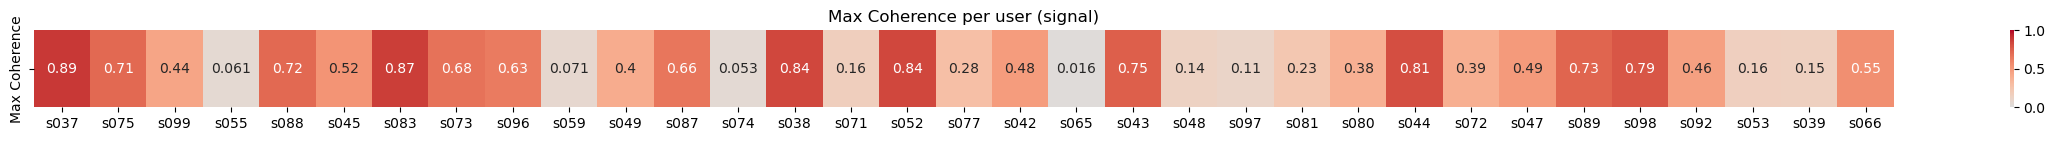

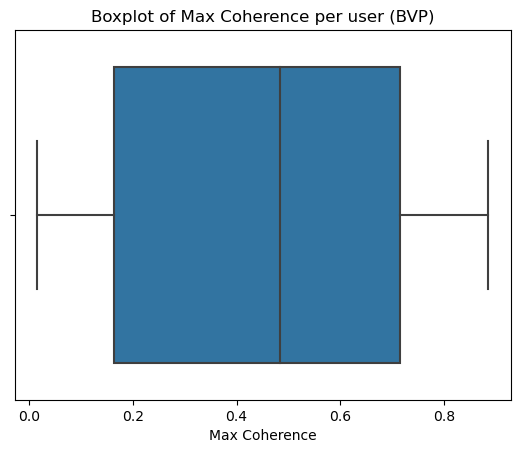

In [55]:
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap


df_to_save: Series = Series(max_cca)
df_to_save = DataFrame(df_to_save, columns=['Max Coherence']).T

figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    center=0,
    vmax=1,
    vmin=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title(f"Max Coherence per user (signal)")
savefig(f"../visualizations/user_max_cca_{signal}.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title(f"Boxplot of Max Coherence per user ({signal})")
savefig(f"../visualizations/user_max_cca_boxplot_{signal}.pdf", bbox_inches="tight")
show()


In [58]:
avg_cca = {user: ca[1].mean() for user, ca in cas.items() if len(ca[1]) > 0}

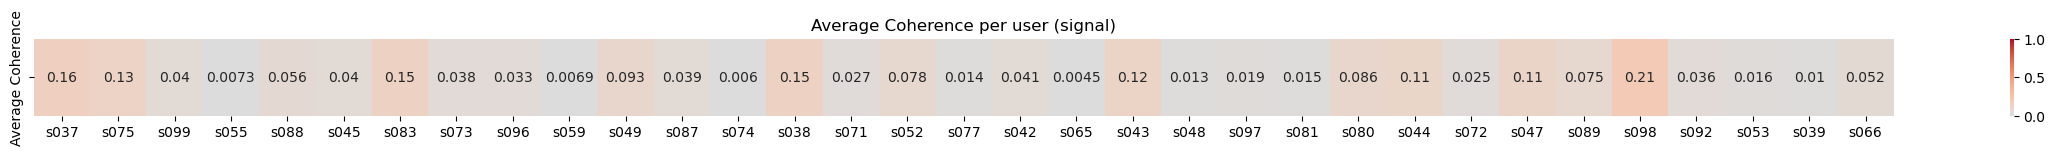

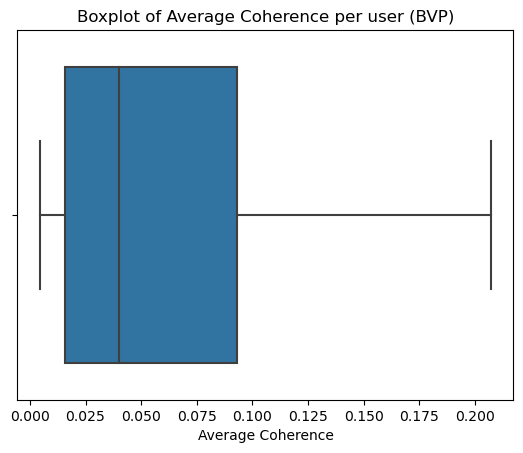

In [59]:
from matplotlib.pyplot import figure, show, savefig, title
from seaborn import heatmap


df_to_save: Series = Series(avg_cca)
df_to_save = DataFrame(df_to_save, columns=['Average Coherence']).T

figure(figsize=(30, 1))
heatmap(
    df_to_save,
    xticklabels=df_to_save.columns,
    vmax=1,
    vmin=0,
    center=0,
    cmap="coolwarm",
    yticklabels=df_to_save.index,
    annot=True,
)
title(f"Average Coherence per user (signal)")
savefig(f"../visualizations/user_average_cca_{signal}.pdf", bbox_inches="tight")
show()
from seaborn import boxplot


boxplot(x=df_to_save.iloc[0, :])
title(f"Boxplot of Average Coherence per user ({signal})")
savefig(f"../visualizations/user_average_cca_boxplot_{signal}.pdf", bbox_inches="tight")
show()
